### Imports

In [5]:
# !LD_LIBRARY_PATH=$HOME/miniconda3/lib:$LD_LIBRARY_PATH
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2024-04-14 02:14:37.283543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-14 02:14:39.897635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 02:14:40.090524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 02:14:40.090581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [6]:
import numpy as np
import tensorflow as tf
import keras
import os, shutil

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import regularizers
import seaborn as sns
from sklearn import metrics
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay

TensorFlow version: 2.14.1
Keras version: 2.14.0


### Visualizing the data

In [7]:

def visualize_confusion_matrix_for_models(X_test, Y_test, *models) -> None:
    """
    Visualizes the confusion matrices for multiple machine learning models.

    Parameters:
        X_test (array-like): Test data features.
        Y_test (array-like): True labels for the test data.
        *models (variable-length argument list): Machine learning models to evaluate.

    Returns:
        None. Displays confusion matrices using seaborn's heatmap.
    """
    num_models = len(models)
    plt.figure(figsize=(5 * num_models, 5))
    for i, model in enumerate(models, 1):
        plt.subplot(1, num_models, i)
        Y_pred = model.predict(X_test)
        Y_pred = (Y_pred > 0.5)
        matrix = metrics.confusion_matrix(Y_test, Y_pred)
        hm = sns.heatmap(matrix,
                         cmap='coolwarm',
                         linecolor='white',
                         linewidths=1,
                         annot=True,
                         fmt='d')
        plt.yticks(rotation=0)
        hm.set_ylim(0, len(matrix))
        plt.title(f'Confusion Matrix - Model {i}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(network, test_generator, samples_count: int) -> None:
    '''
    Plots the confusion matrix for the given network and test generator.
    Parameters:
    network: The network to evaluate.
    test_generator: The test generator to use.
    samples_count: The number of samples to use for the evaluation.
    
    Returns:
    None
    '''
    test_generator.reset()

    confusion_matrix = np.zeros((2, 2))
    used_instances = 0

    for images, labels in test_generator:
        if used_instances >= samples_count:
            break

        used_instances += len(labels)

        predictions = network.predict(images, verbose=False)
        
        predicted_labels = (predictions > 0.5).astype(np.int32).reshape(labels.shape)
        confusion_matrix += tf.math.confusion_matrix(labels, predicted_labels, num_classes=2)

    cm = (confusion_matrix / used_instances).numpy()
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.show()

    print(f"Accuracy: {np.trace(cm)}")

def plot_accuracy_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation accuracy comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation accuracy values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots

    for i, history in enumerate(histories):
        epochs = np.arange(1, len(history.history['acc']) + 1)
        
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        
        plt.plot(epochs, acc, color + 'o', label=f'Training accuracy for {label}')
        plt.plot(epochs, val_acc, color, label=f'Validation accuracy for {label}')

    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



def plot_loss_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation loss comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation loss values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots
    epochs = np.arange(1, len(histories[0].history['loss']) + 1)  # Assuming all models have the same number of epochs

    for i, history in enumerate(histories):
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        plt.plot(epochs, loss, color + 'o', label=f'Training loss for {label}')
        plt.plot(epochs, val_loss, color, label=f'Validation loss for {label}')

    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
def print_val_accuracies(history1, history2, history3):
    val_accuracy1 = history1.history['val_acc']
    val_accuracy2 = history2.history['val_acc']
    val_accuracy3 = history3.history['val_acc']

    argmax1 = np.argmax(val_accuracy1)
    argmax2 = np.argmax(val_accuracy2)
    argmax3 = np.argmax(val_accuracy3)

    print ('Max accuracy for model 1 is: ', val_accuracy1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
    print ('Max accuracy for model 2 is: ', val_accuracy2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
    print ('Max accuracy for model 3 is: ', val_accuracy3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

### Get data

In [8]:
kaggle_dir = "kaggle"
    
processed_dir = kaggle_dir + "/processed"

cats_and_dogs_small_dir = processed_dir + "/cats_and_dogs_small"

base_dir = cats_and_dogs_small_dir + "/"

train_dir: str = base_dir + "train/"

train_cats_dir: str = train_dir + "cats/"
train_dogs_dir: str = train_dir + "dogs/"

validation_dir: str = base_dir + "validation/"

validation_cats_dir: str = validation_dir + "cats/"
validation_dogs_dir: str = validation_dir + "dogs/"

test_dir: str = base_dir + "test/"

test_cats_dir: str = test_dir + "cats/"
test_dogs_dir: str = test_dir + "dogs/"

models_dir: str = "models/"

In [9]:
from pathlib import Path

def create_dir_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def create_dirs():
    all_paths: list[str] = [kaggle_dir, processed_dir, cats_and_dogs_small_dir,
                            base_dir, train_dir, train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir, test_cats_dir, test_dogs_dir]
    
    for path in all_paths:
        create_dir_if_not_exists(path)

def copy_train_images(indices: np.ndarray, animal: str ='cat', dir_type: str ='train'):
    for index in indices:
        src: str = f"kaggle/original/train/{animal}.{index}.jpg"
        dst: str = f"kaggle/processed/cats_and_dogs_small/{dir_type}/{animal}s/{animal}.{index}.jpg"
        shutil.copyfile(src, dst)

def remove_images():
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir, ignore_errors=True)

def copy_all_images(validation_size=500, test_size=1000, max_train_size=20000):
    remove_images()

    create_dirs()
    print("Dirs created")
    
    files: list[str] = os.listdir("kaggle/original/train")

    cats_count: int = sum(1 for file in files if file.startswith("cat"))
    dogs_count: int = sum(1 for file in files if file.startswith("dog"))

    train_size_cats: int = min(cats_count - validation_size - test_size, max_train_size)
    train_size_dogs: int = min(dogs_count - validation_size - test_size, max_train_size)

    indices_cats = np.random.permutation(cats_count)
    indices_dogs = np.random.permutation(dogs_count)

    indices_cats_train = indices_cats[:train_size_cats]
    indices_dogs_train = indices_dogs[:train_size_dogs]

    indices_cats_validation = indices_cats[train_size_cats:train_size_cats + validation_size]
    indices_dogs_validation = indices_dogs[train_size_dogs:train_size_dogs + validation_size]

    indices_cats_test = indices_cats[train_size_cats + validation_size:train_size_cats + validation_size + test_size]
    indices_dogs_test = indices_dogs[train_size_dogs + validation_size:train_size_dogs + validation_size + test_size]


    copy_train_images(indices_cats_train, 'cat', 'train')
    copy_train_images(indices_dogs_train, 'dog', 'train')
    print("Train images copied")

    copy_train_images(indices_cats_validation, 'cat', 'validation')
    copy_train_images(indices_dogs_validation, 'dog', 'validation')
    print("Validation images copied")

    copy_train_images(indices_cats_test, 'cat', 'test')
    copy_train_images(indices_dogs_test, 'dog', 'test')
    print("Test images copied")

    print("All images copied")

In [10]:
copy_all_images(max_train_size=4000)

Dirs created
Train images copied
Validation images copied
Test images copied
All images copied


# Model

## Number of epochs

In [11]:
epochs_count: int = 4

## Structure

In [12]:
img_rows, img_cols = 150, 150

model1_a = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model1_a.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

model1_a.summary()

2024-04-14 02:14:47.199812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 02:14:47.200001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 02:14:47.200063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 02:14:47.433067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 02:14:47.433134: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [13]:
model2_a = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model2_a.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model2_a.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 72, 72, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_7 (Conv2D)           (None, 70, 70, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 70, 70, 128)      

 batch_normalization_2 (Bat  (None, 33, 33, 128)       512       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 31, 31, 128)       147584    
                                                                 
 batch_normalization_3 (Bat  (None, 31, 31, 128)       512       
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 123008)            0         
                                                                 
 dropout_1 (Dropout)         (None, 123008)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               31490304  
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
          

In [14]:
model3_a = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model3_a.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model3_a.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 conv2d_12 (Conv2D)          (None, 144, 144, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 72, 72, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 70, 70, 64)        36928     
                                                                 
 batch_normalization_4 (Bat  (None, 70, 70, 64)        256       
 chNormalization)                                     

In [15]:
model4_a = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model4_a.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model4_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_18 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 144, 144, 32)      9248      
                                                                 
 batch_normalization_8 (Bat  (None, 144, 144, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 46, 46, 64)       

In [16]:
model5_a = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model5_a.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model5_a.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_27 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 conv2d_28 (Conv2D)          (None, 144, 144, 32)      9248      
                                                                 
 batch_normalization_14 (Ba  (None, 144, 144, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 46, 46, 64)       

## Data Augumentation

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Training

In [18]:
# history1 = model1.fit_generator(
history1_a = model1_a.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs_count,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/4


2024-04-14 02:14:51.042442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-04-14 02:14:51.304898: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-14 02:14:52.126738: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-14 02:14:51.552070: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efedc2b1980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-14 02:14:51.552172: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-04-14 02:14:51.560809: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-14 02:14:51.650457: I ./tensorflow/compiler/jit/device_comp

100/100 [==============================] - 17s 135ms/step - loss: 0.6933 - acc: 0.5155 - val_loss: 0.6926 - val_acc: 0.5100
Epoch 2/4
100/100 [==============================] - 13s 130ms/step - loss: 0.6920 - acc: 0.5255 - val_loss: 0.6967 - val_acc: 0.5000
Epoch 3/4
100/100 [==============================] - 11s 111ms/step - loss: 0.6894 - acc: 0.5285 - val_loss: 0.7004 - val_acc: 0.5000
Epoch 4/4
100/100 [==============================] - 13s 131ms/step - loss: 0.6932 - acc: 0.5280 - val_loss: 0.6920 - val_acc: 0.5050


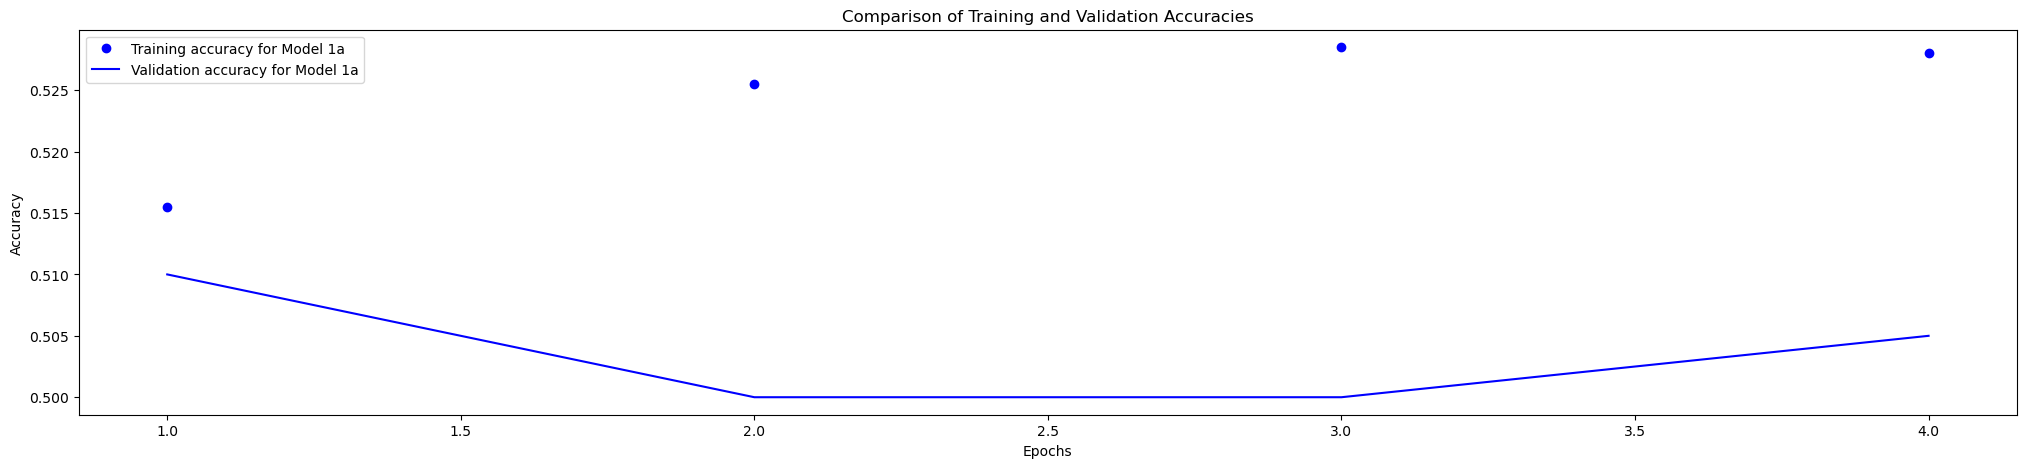

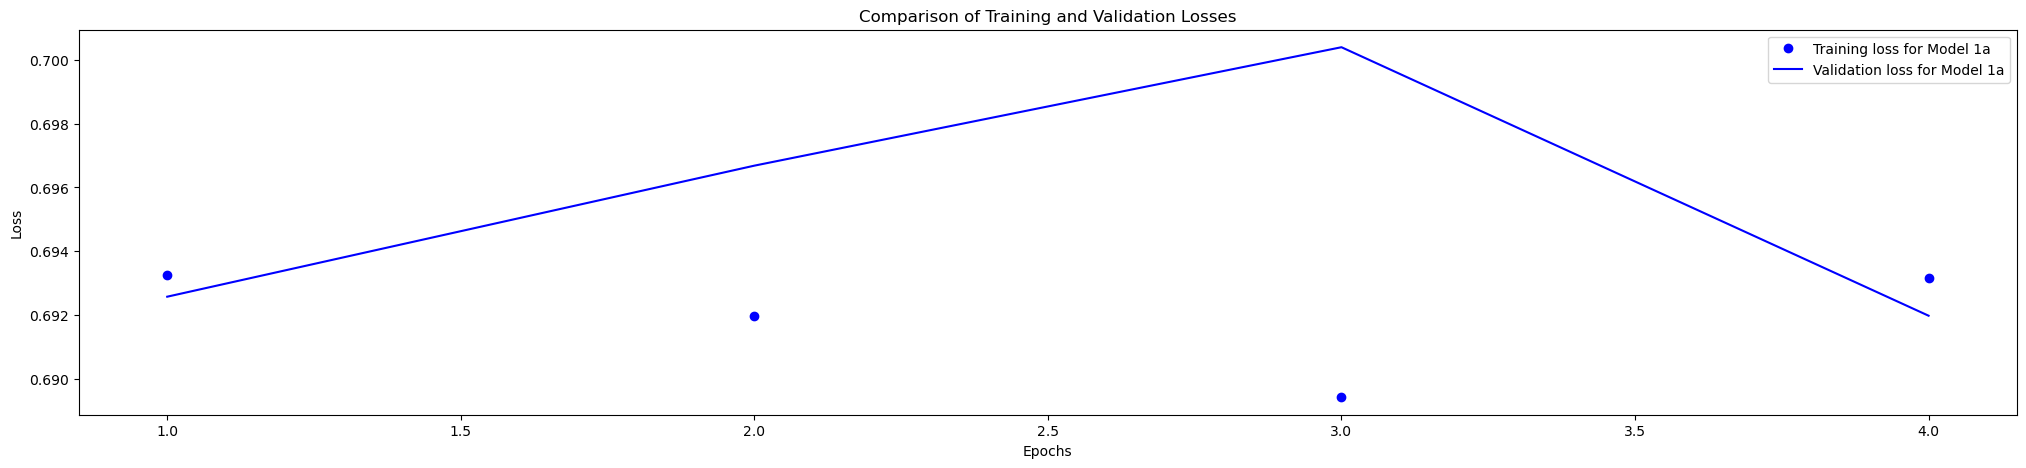

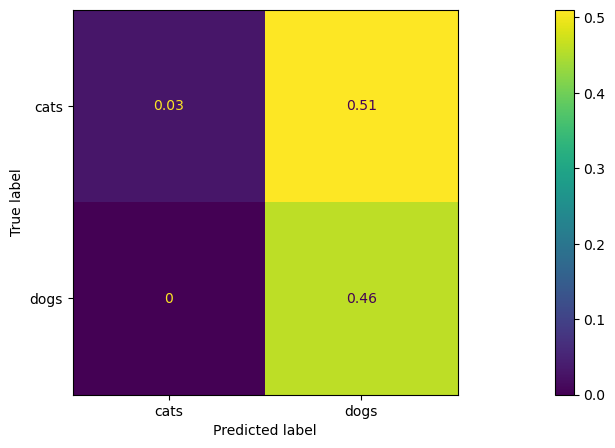

Accuracy: 0.49


In [19]:
plot_accuracy_comparison(history1_a, labels=['Model 1a'])
plot_loss_comparison(history1_a, labels=['Model 1a'])
plot_confusion_matrix(model1_a, validation_generator, 100)

In [20]:
history2_a = model2_a.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50)

Epoch 1/4
100/100 [==============================] - 15s 118ms/step - loss: 1.9634 - acc: 0.5820 - val_loss: 1.6727 - val_acc: 0.5000
Epoch 2/4
100/100 [==============================] - 14s 139ms/step - loss: 1.7560 - acc: 0.5925 - val_loss: 2.5450 - val_acc: 0.5000
Epoch 3/4
100/100 [==============================] - 13s 125ms/step - loss: 1.4744 - acc: 0.5720 - val_loss: 3.3033 - val_acc: 0.5010
Epoch 4/4
100/100 [==============================] - 14s 143ms/step - loss: 1.1943 - acc: 0.6110 - val_loss: 4.9021 - val_acc: 0.5020


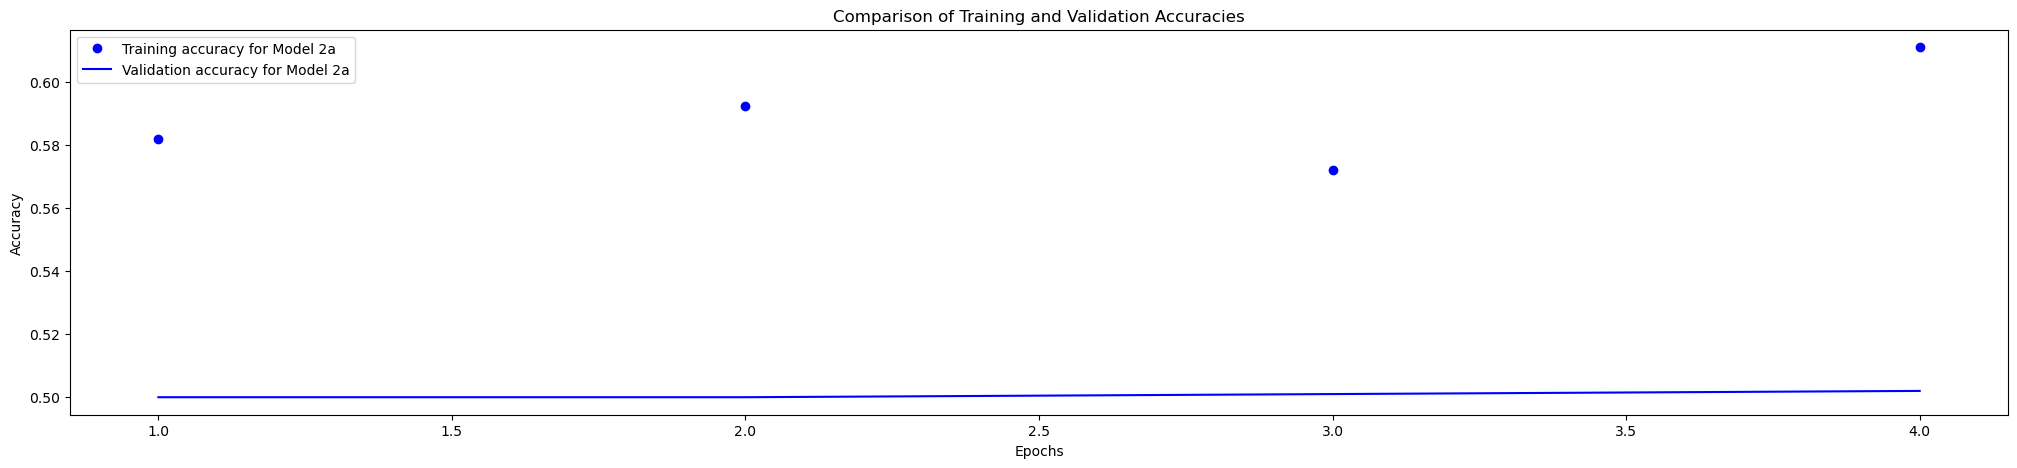

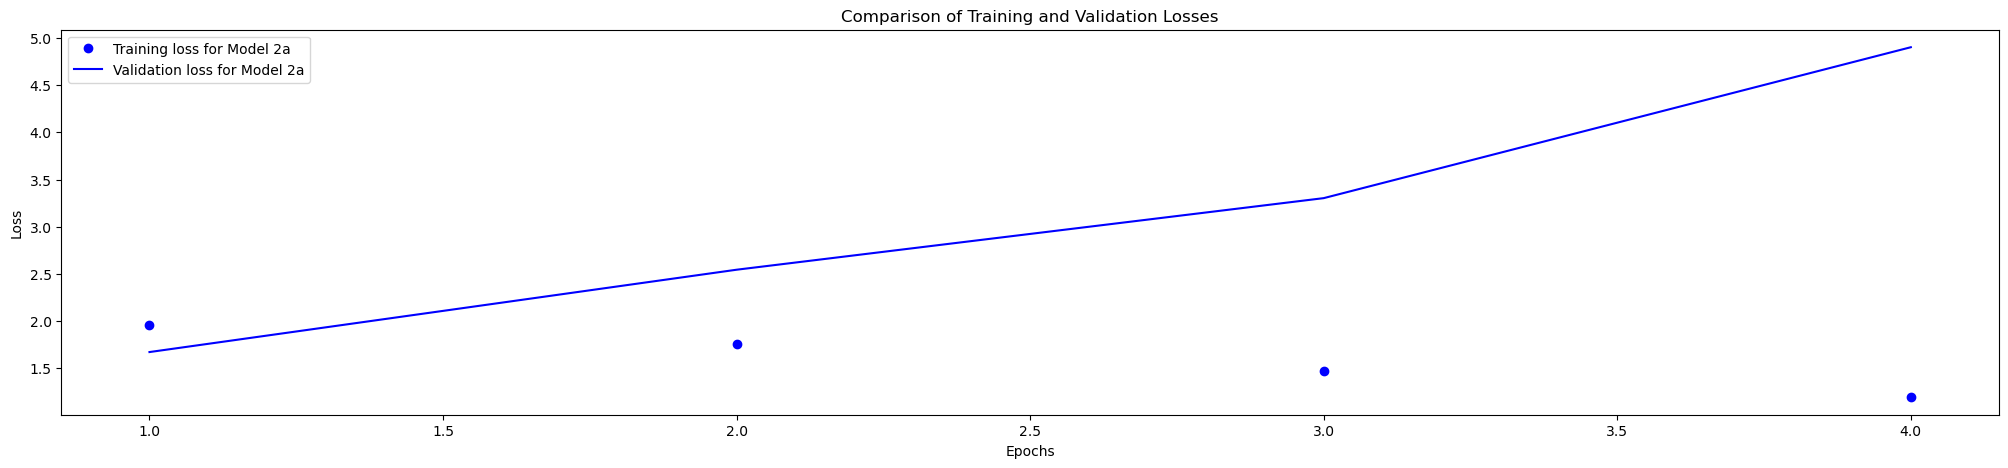

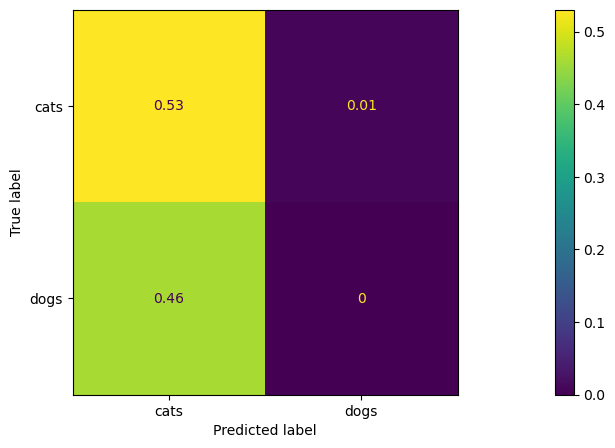

Accuracy: 0.53


In [21]:
plot_accuracy_comparison(history2_a, labels=['Model 2a'])
plot_loss_comparison(history2_a, labels=['Model 2a'])
plot_confusion_matrix(model2_a, validation_generator, 100)

In [22]:
history3_a = model3_a.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4


2024-04-14 02:16:45.365084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 19s 117ms/step - loss: 0.9372 - acc: 0.5495 - val_loss: 0.7266 - val_acc: 0.5000
Epoch 2/4
100/100 [==============================] - 13s 129ms/step - loss: 0.8320 - acc: 0.5645 - val_loss: 0.7178 - val_acc: 0.5000
Epoch 3/4
100/100 [==============================] - 12s 115ms/step - loss: 0.7864 - acc: 0.5715 - val_loss: 1.5306 - val_acc: 0.5000
Epoch 4/4
100/100 [==============================] - 13s 129ms/step - loss: 0.7317 - acc: 0.6085 - val_loss: 1.7564 - val_acc: 0.5000


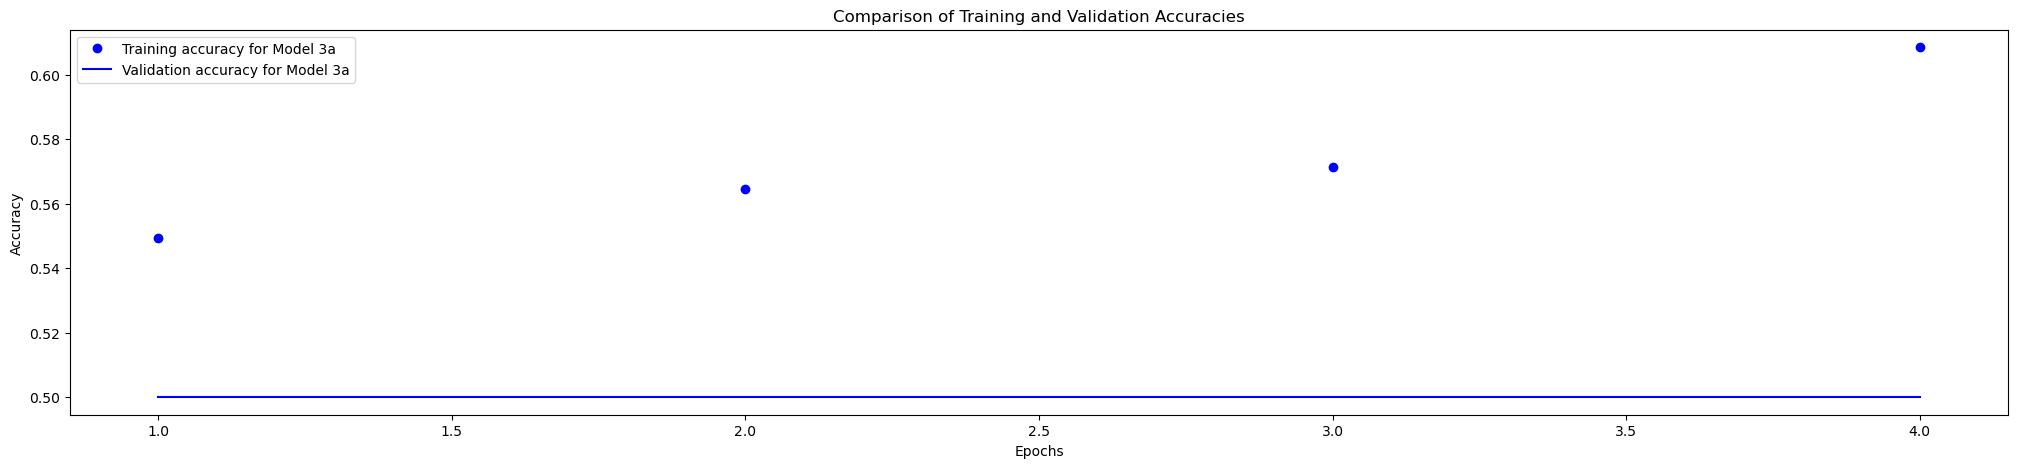

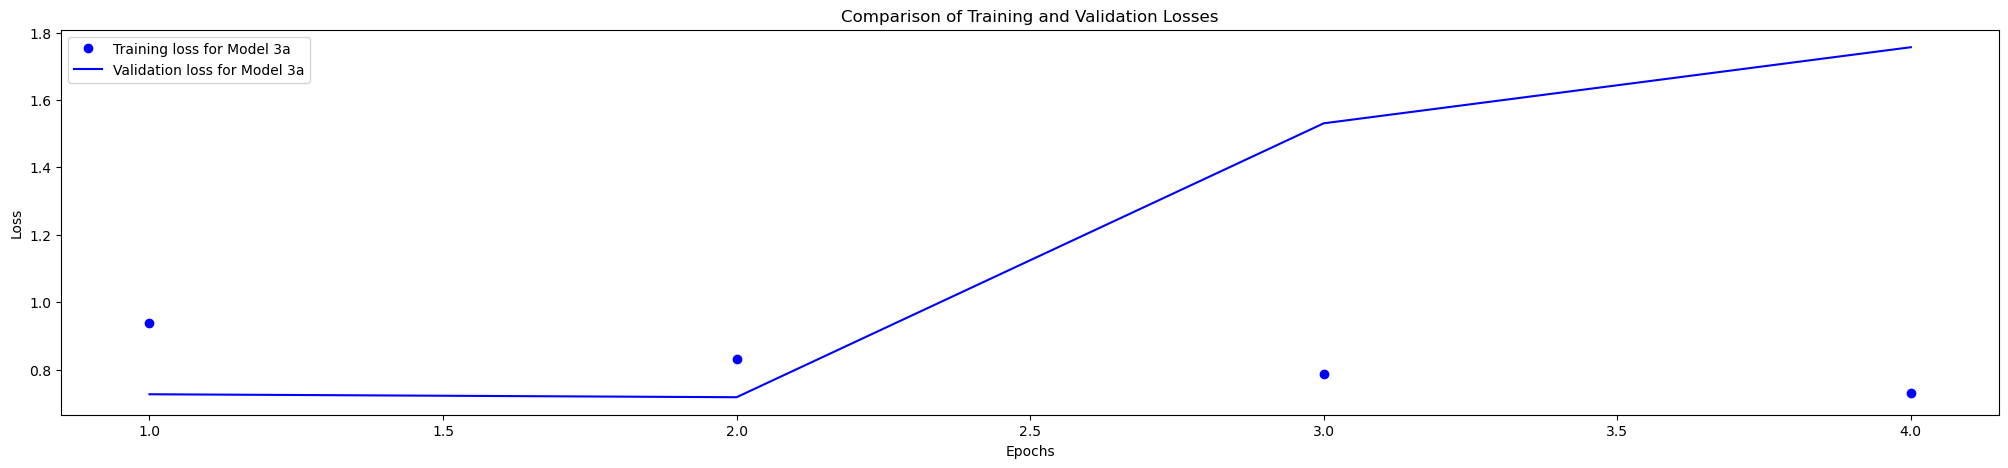

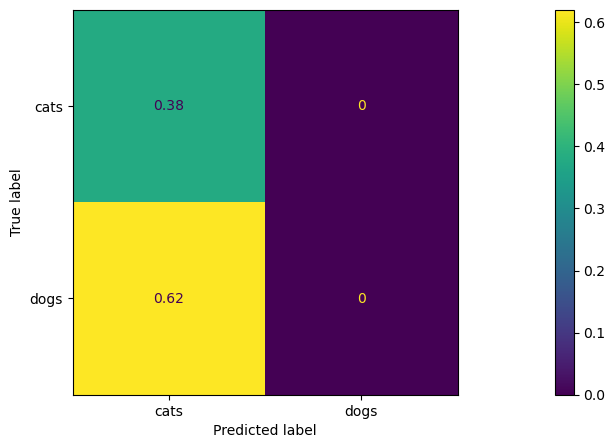

Accuracy: 0.38


In [23]:
plot_accuracy_comparison(history3_a, labels=['Model 3a'])
plot_loss_comparison(history3_a, labels=['Model 3a'])
plot_confusion_matrix(model3_a, validation_generator, 100)

In [24]:
history4_a = model4_a.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4
100/100 [==============================] - 18s 112ms/step - loss: 0.9270 - acc: 0.5470 - val_loss: 0.8852 - val_acc: 0.5000
Epoch 2/4
100/100 [==============================] - 13s 125ms/step - loss: 0.8830 - acc: 0.5670 - val_loss: 1.5419 - val_acc: 0.5000
Epoch 3/4
100/100 [==============================] - 13s 125ms/step - loss: 0.8493 - acc: 0.5650 - val_loss: 1.0737 - val_acc: 0.5000
Epoch 4/4
100/100 [==============================] - 11s 110ms/step - loss: 0.8396 - acc: 0.5815 - val_loss: 0.9778 - val_acc: 0.5160


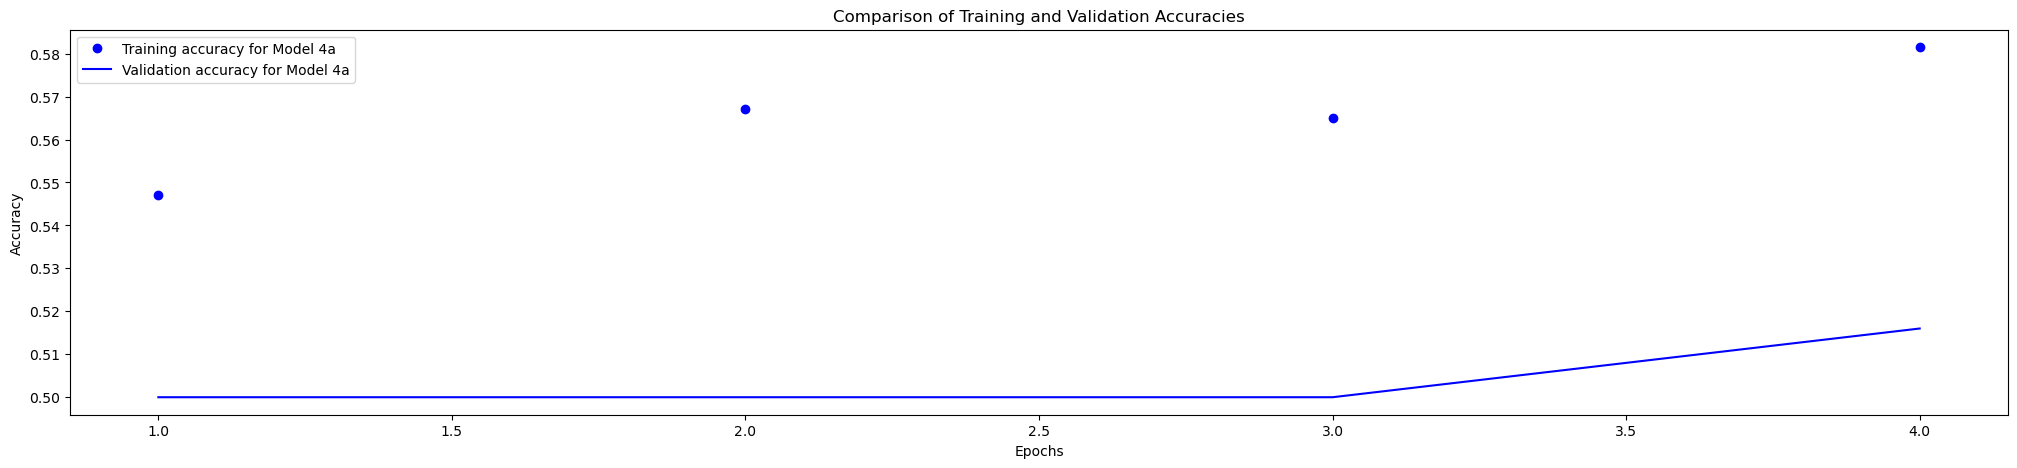

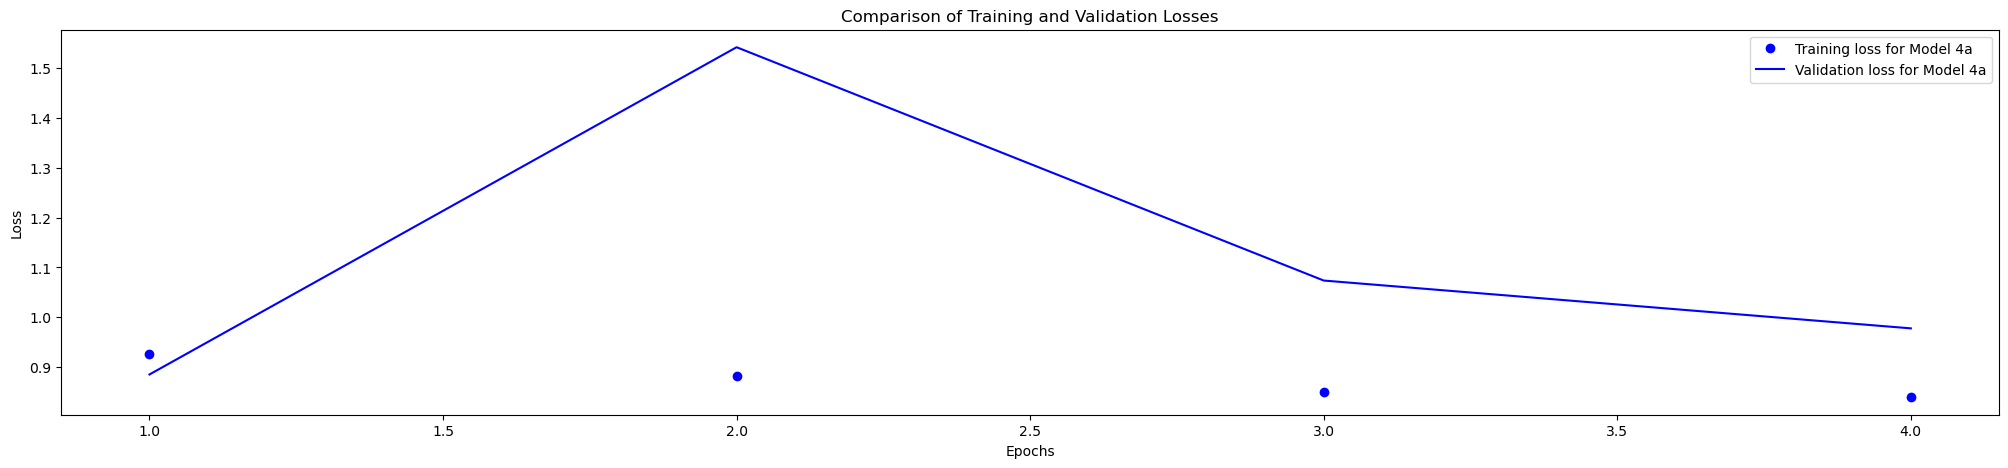

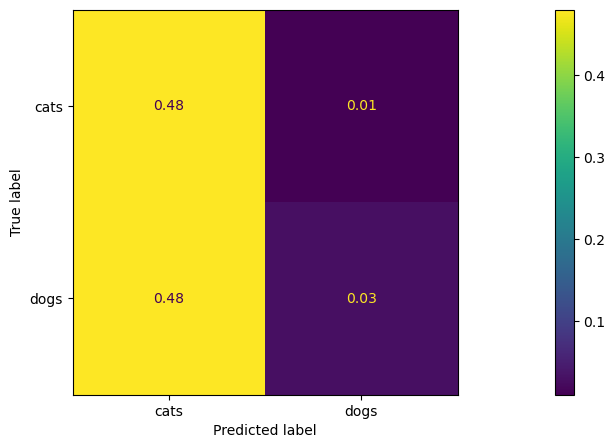

Accuracy: 0.51


In [25]:
plot_accuracy_comparison(history4_a, labels=['Model 4a'])
plot_loss_comparison(history4_a, labels=['Model 4a'])
plot_confusion_matrix(model4_a, validation_generator, 100)

In [26]:
history5_a = model5_a.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4


2024-04-14 02:18:38.519016: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 17s 129ms/step - loss: 0.8814 - acc: 0.5285 - val_loss: 0.8294 - val_acc: 0.5000
Epoch 2/4
100/100 [==============================] - 11s 111ms/step - loss: 0.8286 - acc: 0.5570 - val_loss: 0.9013 - val_acc: 0.5000
Epoch 3/4
100/100 [==============================] - 13s 129ms/step - loss: 0.8085 - acc: 0.5800 - val_loss: 1.2821 - val_acc: 0.5000
Epoch 4/4
100/100 [==============================] - 11s 110ms/step - loss: 0.8172 - acc: 0.5660 - val_loss: 0.7967 - val_acc: 0.5340


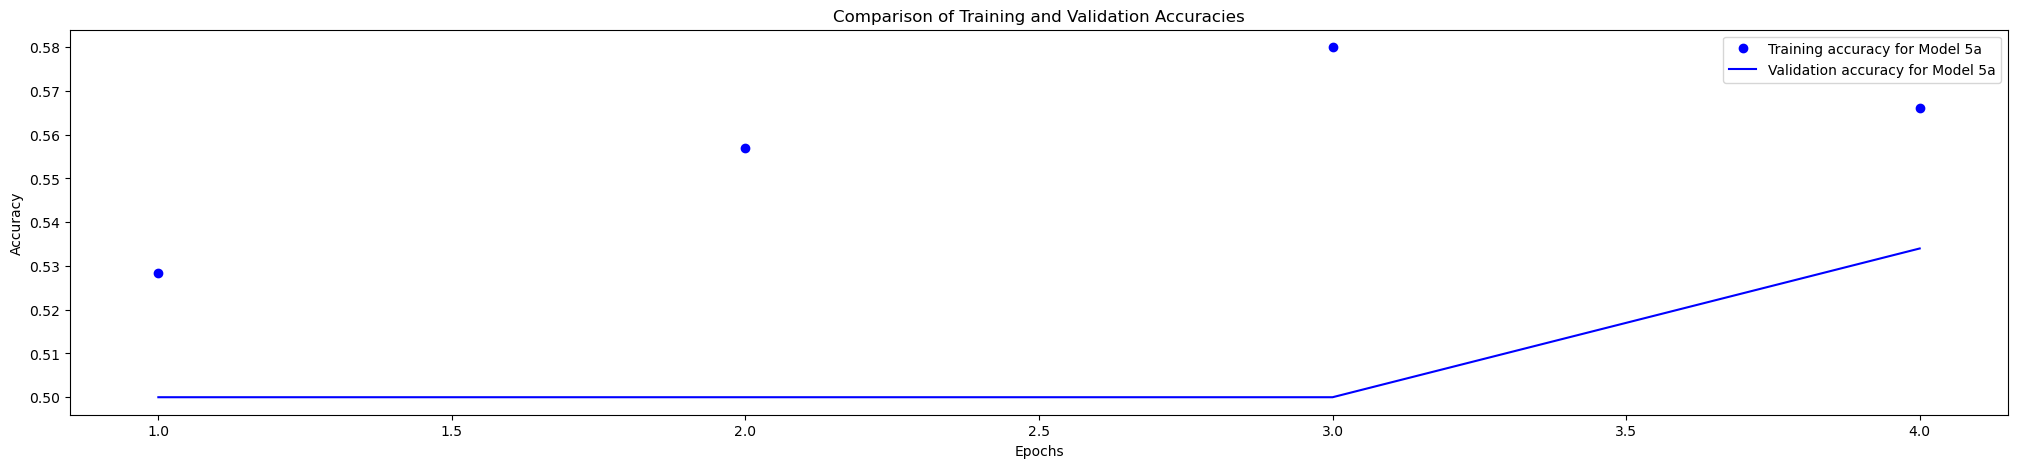

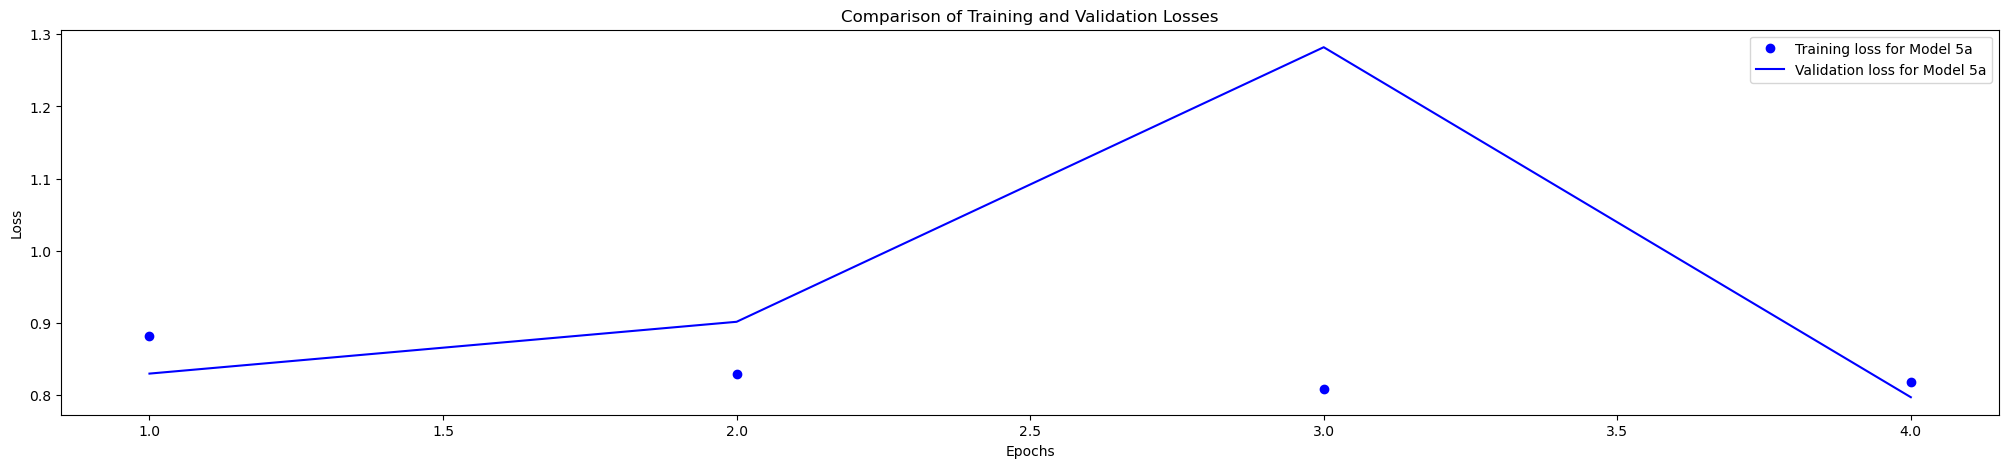

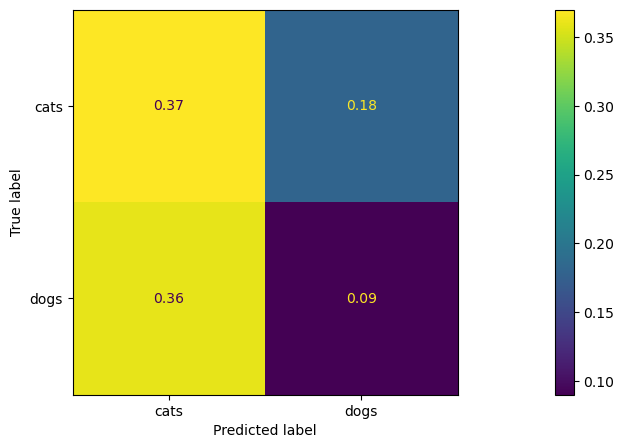

Accuracy: 0.45999999999999996


In [27]:
plot_accuracy_comparison(history5_a, labels=['Model 5a'])
plot_loss_comparison(history5_a, labels=['Model 5a'])
plot_confusion_matrix(model5_a, validation_generator, 100)

## Save model

In [28]:
model1_a.save(models_dir + 'cats_and_dogs_1.keras')
model2_a.save(models_dir + 'cats_and_dogs_2.keras')
model3_a.save(models_dir + 'cats_and_dogs_3.keras')
model4_a.save(models_dir + 'cats_and_dogs_4.keras')
model5_a.save(models_dir + 'cats_and_dogs_5.keras')


## Visualizing the metrics

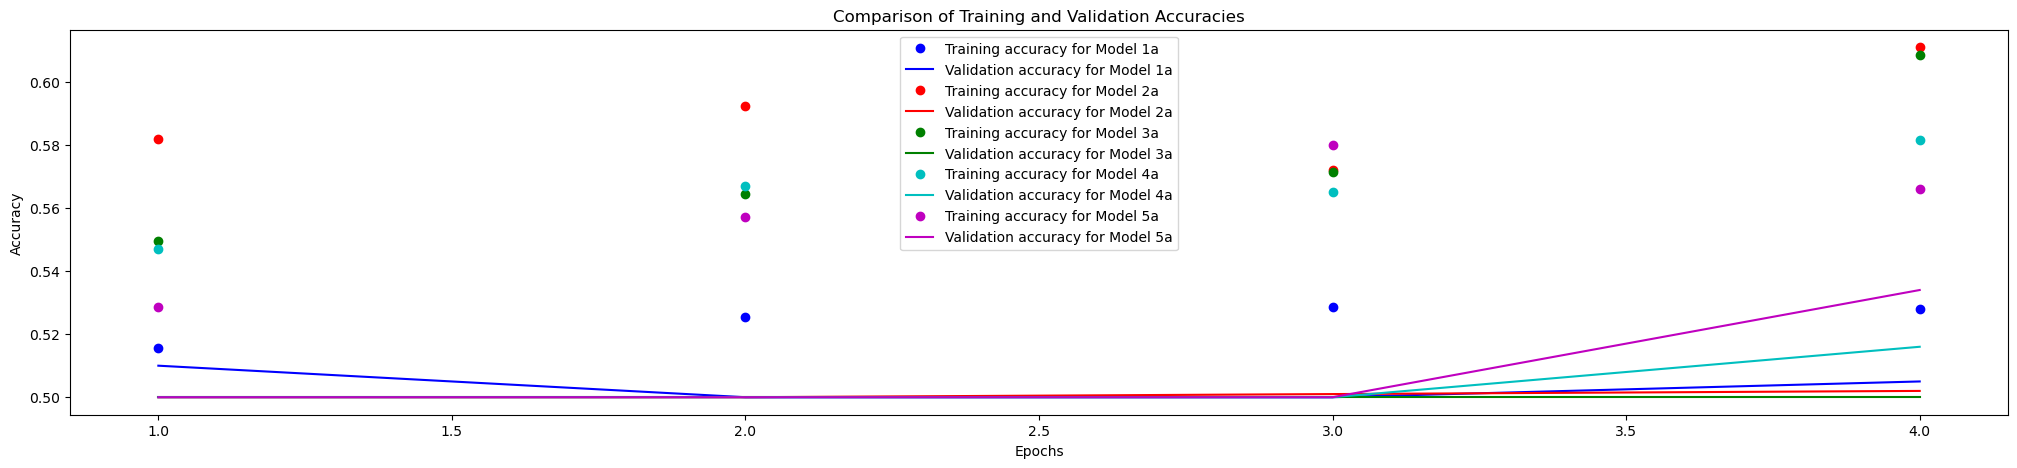

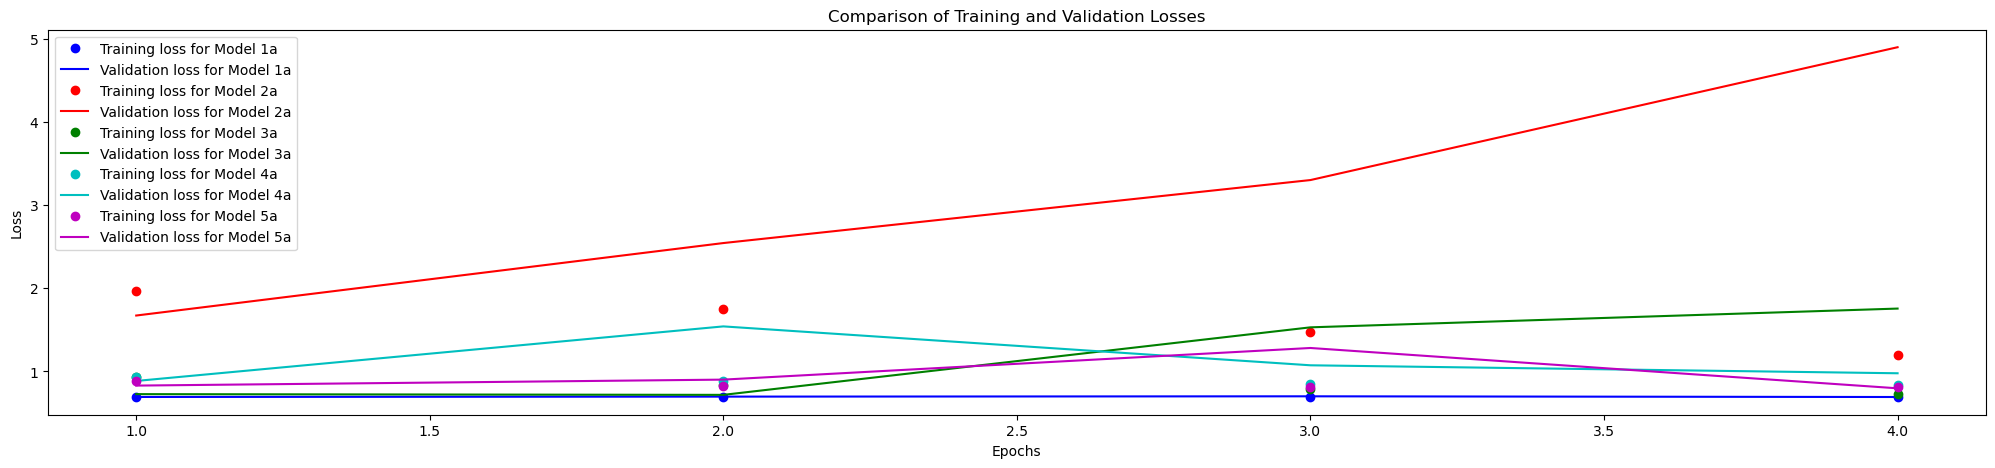

Max accuracy for model 1 is:  0.5099999904632568 , achieved in the  0 epoch.
Max accuracy for model 2 is:  0.5019999742507935 , achieved in the  3 epoch.
Max accuracy for model 3 is:  0.5 , achieved in the  0 epoch.


In [29]:
plot_accuracy_comparison(history1_a, history2_a, history3_a, history4_a, history5_a, labels=['Model 1a', 'Model 2a', 'Model 3a', 'Model 4a', 'Model 5a'])
plot_loss_comparison(history1_a, history2_a, history3_a, history4_a, history5_a, labels=['Model 1a', 'Model 2a', 'Model 3a', 'Model 4a', 'Model 5a'])
print_val_accuracies(history1_a, history2_a, history3_a)


# Increase number of training samples - 12000

In [30]:
copy_all_images(max_train_size=12000)

Dirs created
Train images copied
Validation images copied
Test images copied
All images copied


In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        class_mode='binary')

Found 22000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## CNNs

In [32]:
img_rows, img_cols = 150, 150

model1_b = tf.keras.models.clone_model(model1_a)

model1_b.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

model1_b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [33]:
model2_b = tf.keras.models.clone_model(model2_a)

model2_b.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model2_b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 72, 72, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_7 (Conv2D)           (None, 70, 70, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 70, 70, 128)      

In [34]:
model3_b = model6 = tf.keras.models.clone_model(model3_a)

model3_b.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model3_b.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 conv2d_12 (Conv2D)          (None, 144, 144, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 72, 72, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 70, 70, 64)        36928     
                                                                 
 batch_normalization_4 (Bat  (None, 70, 70, 64)        256       
 chNormalization)                                     

In [35]:
model4_b = tf.keras.models.clone_model(model4_a)
model4_b.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model4_b.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_18 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 144, 144, 32)      9248      
                                                                 
 batch_normalization_8 (Bat  (None, 144, 144, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 46, 46, 64)       

In [36]:
model5_b = tf.keras.models.clone_model(model5_a)

model5_b.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model5_b.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_27 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 conv2d_28 (Conv2D)          (None, 144, 144, 32)      9248      
                                                                 
 batch_normalization_14 (Ba  (None, 144, 144, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 46, 46, 64)       

## Learning

In [37]:
history1_b = model1_b.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4
100/100 [==============================] - 13s 111ms/step - loss: 0.6948 - acc: 0.5020 - val_loss: 0.6925 - val_acc: 0.5660
Epoch 2/4
100/100 [==============================] - 13s 131ms/step - loss: 0.6932 - acc: 0.5020 - val_loss: 0.6917 - val_acc: 0.5030
Epoch 3/4
100/100 [==============================] - 13s 128ms/step - loss: 0.6928 - acc: 0.5205 - val_loss: 0.6906 - val_acc: 0.5040
Epoch 4/4
100/100 [==============================] - 12s 121ms/step - loss: 0.6890 - acc: 0.5435 - val_loss: 0.6855 - val_acc: 0.5320


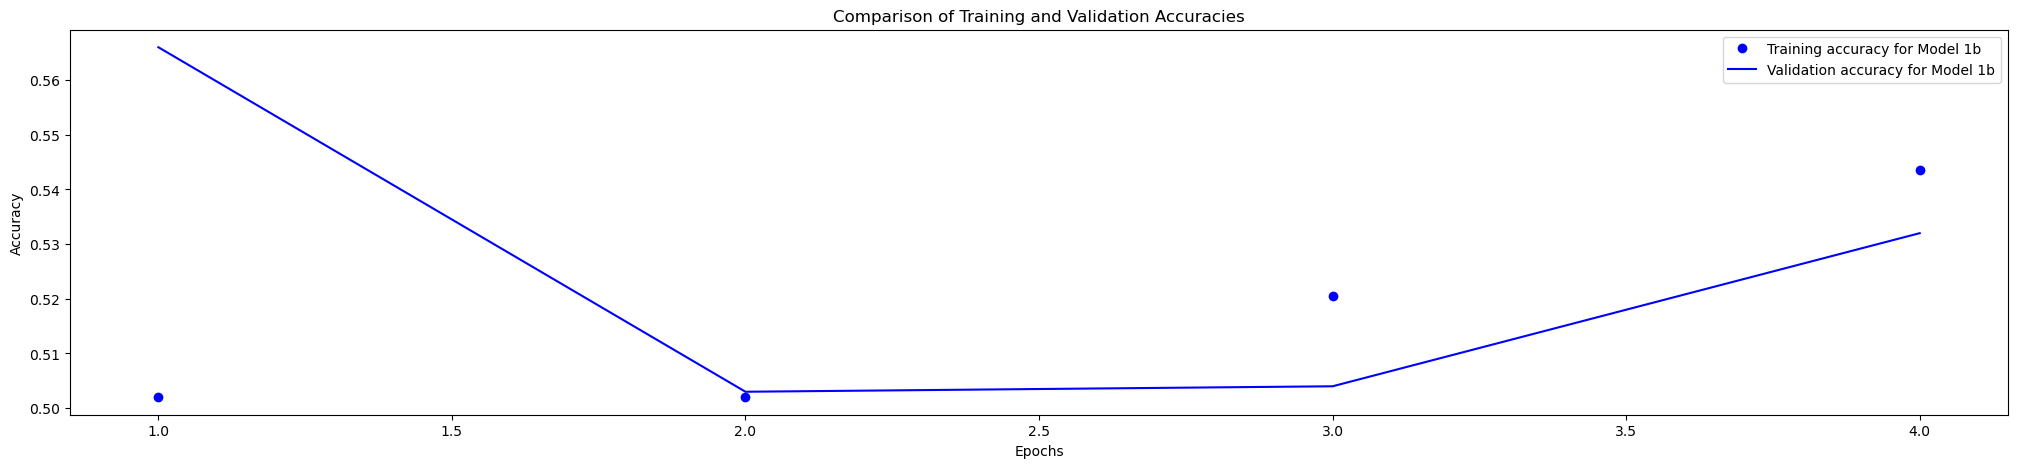

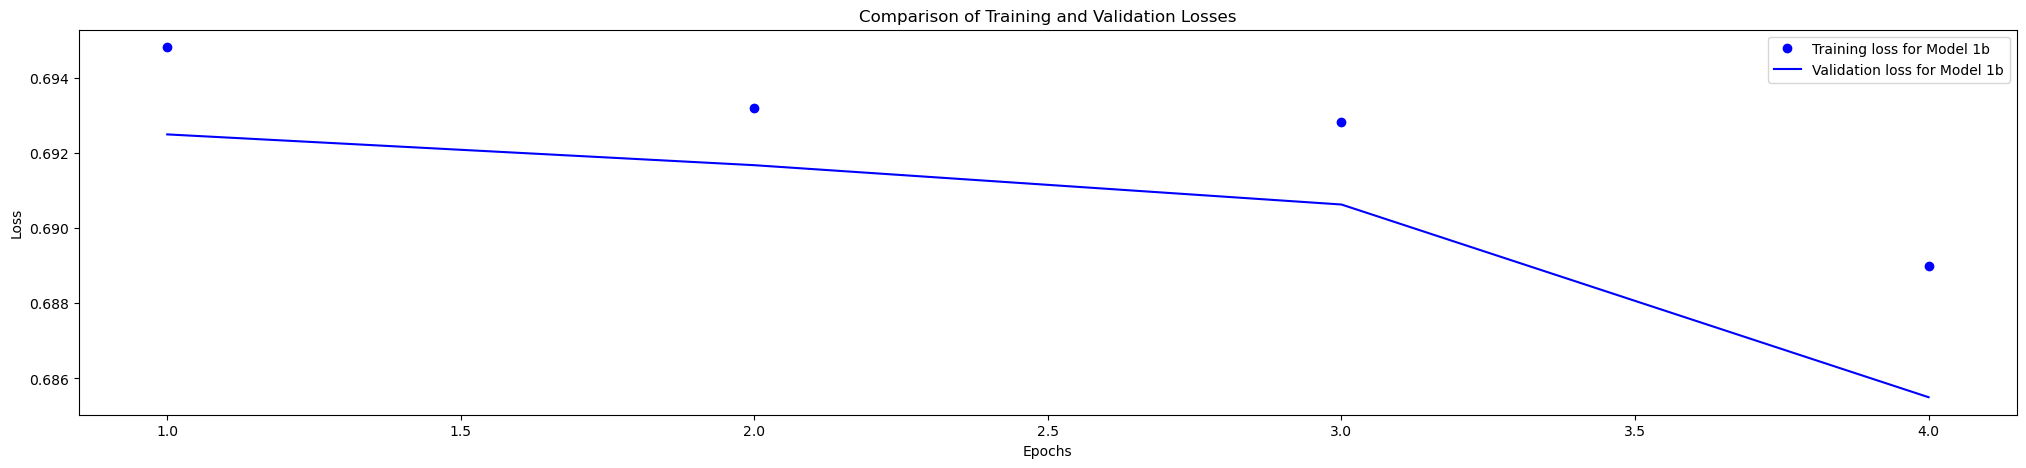

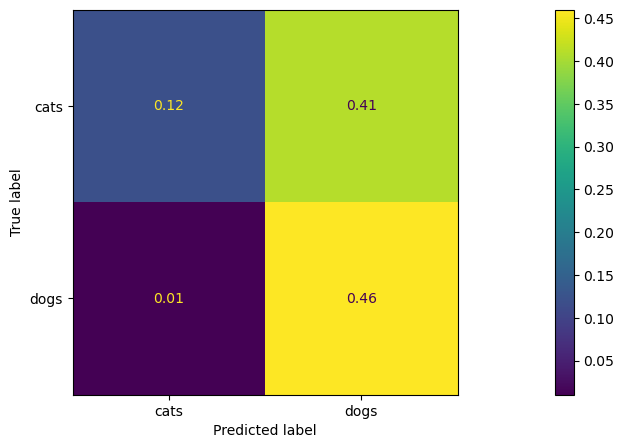

Accuracy: 0.5800000000000001


In [38]:
plot_accuracy_comparison(history1_b, labels=['Model 1b'])
plot_loss_comparison(history1_b, labels=['Model 1b'])
plot_confusion_matrix(model1_b, validation_generator, 100)

In [39]:
history2_b = model2_b.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4
100/100 [==============================] - 16s 136ms/step - loss: 1.9662 - acc: 0.5735 - val_loss: 0.8952 - val_acc: 0.5000
Epoch 2/4
100/100 [==============================] - 12s 120ms/step - loss: 1.8943 - acc: 0.5810 - val_loss: 0.8166 - val_acc: 0.5300
Epoch 3/4
100/100 [==============================] - 13s 130ms/step - loss: 1.6012 - acc: 0.5910 - val_loss: 2.4556 - val_acc: 0.5080
Epoch 4/4
100/100 [==============================] - 11s 110ms/step - loss: 1.4104 - acc: 0.5930 - val_loss: 1.8377 - val_acc: 0.5440


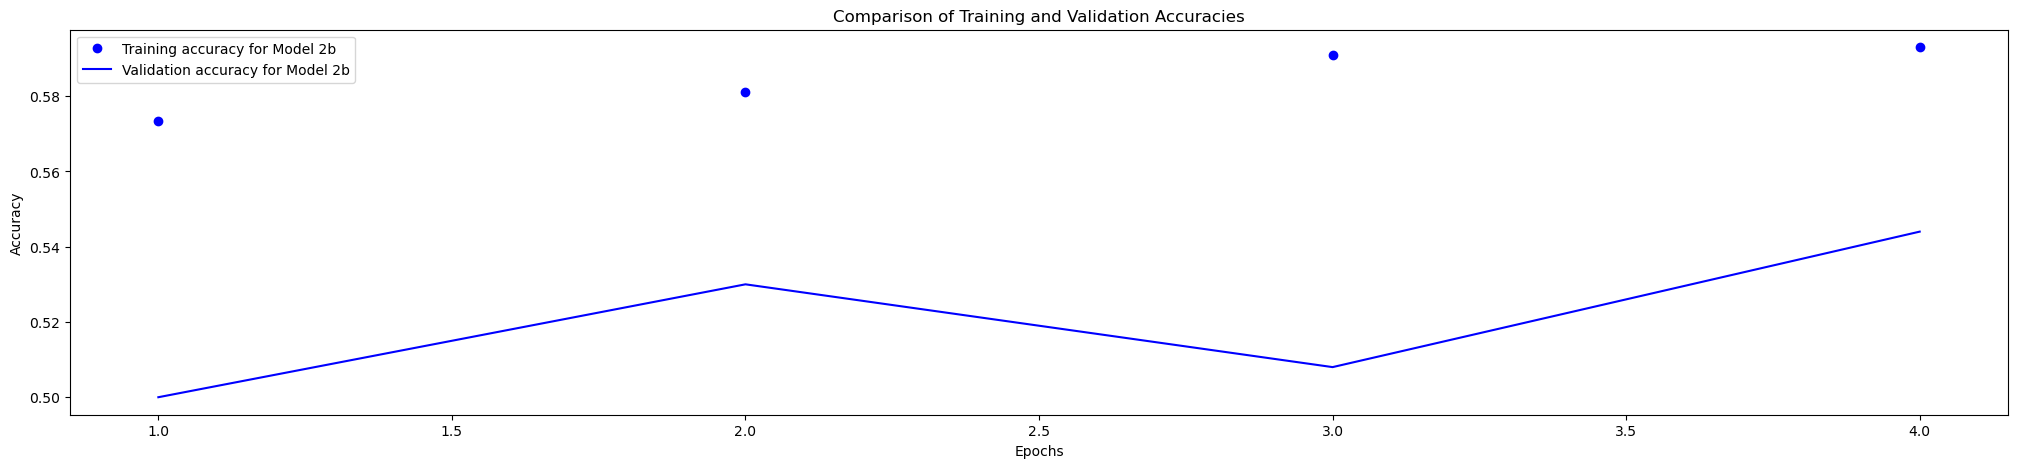

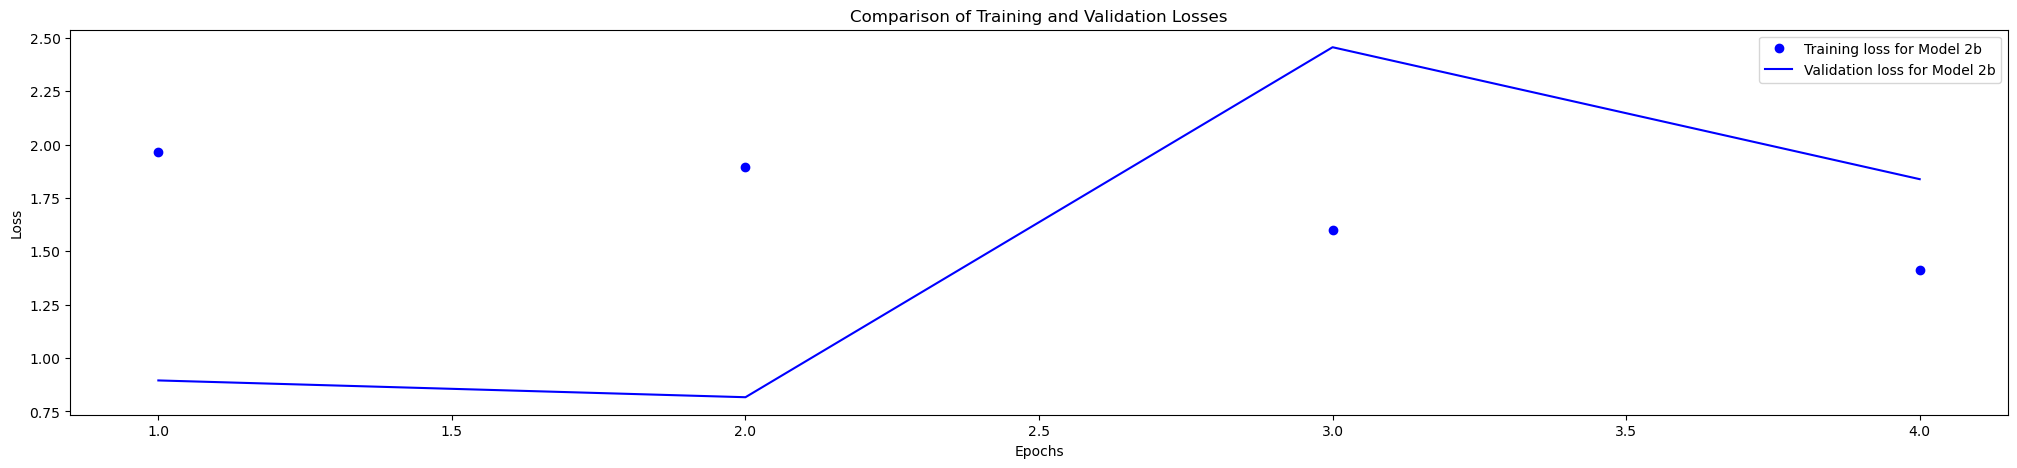

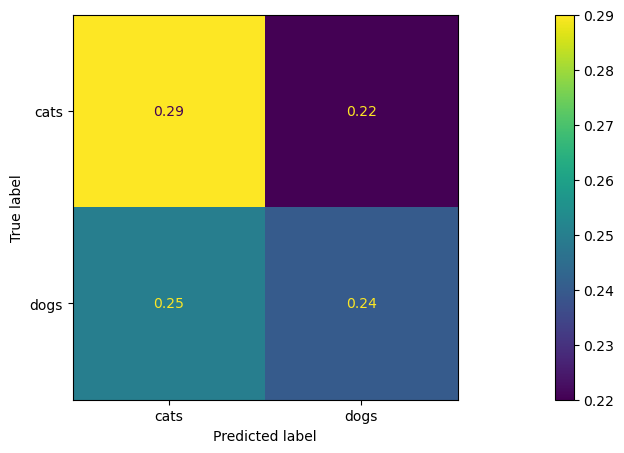

Accuracy: 0.53


In [40]:
plot_accuracy_comparison(history2_b, labels=['Model 2b'])
plot_loss_comparison(history2_b, labels=['Model 2b'])
plot_confusion_matrix(model2_b, validation_generator, 100)

In [41]:
history3_b = model3_b.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4


2024-04-14 02:21:36.875773: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 18s 146ms/step - loss: 0.9756 - acc: 0.5350 - val_loss: 0.7454 - val_acc: 0.5000
Epoch 2/4
100/100 [==============================] - 13s 128ms/step - loss: 0.8391 - acc: 0.5790 - val_loss: 0.6890 - val_acc: 0.5190
Epoch 3/4
100/100 [==============================] - 14s 144ms/step - loss: 0.8010 - acc: 0.5785 - val_loss: 0.8864 - val_acc: 0.5000
Epoch 4/4
100/100 [==============================] - 13s 128ms/step - loss: 0.7614 - acc: 0.5965 - val_loss: 0.7041 - val_acc: 0.5730


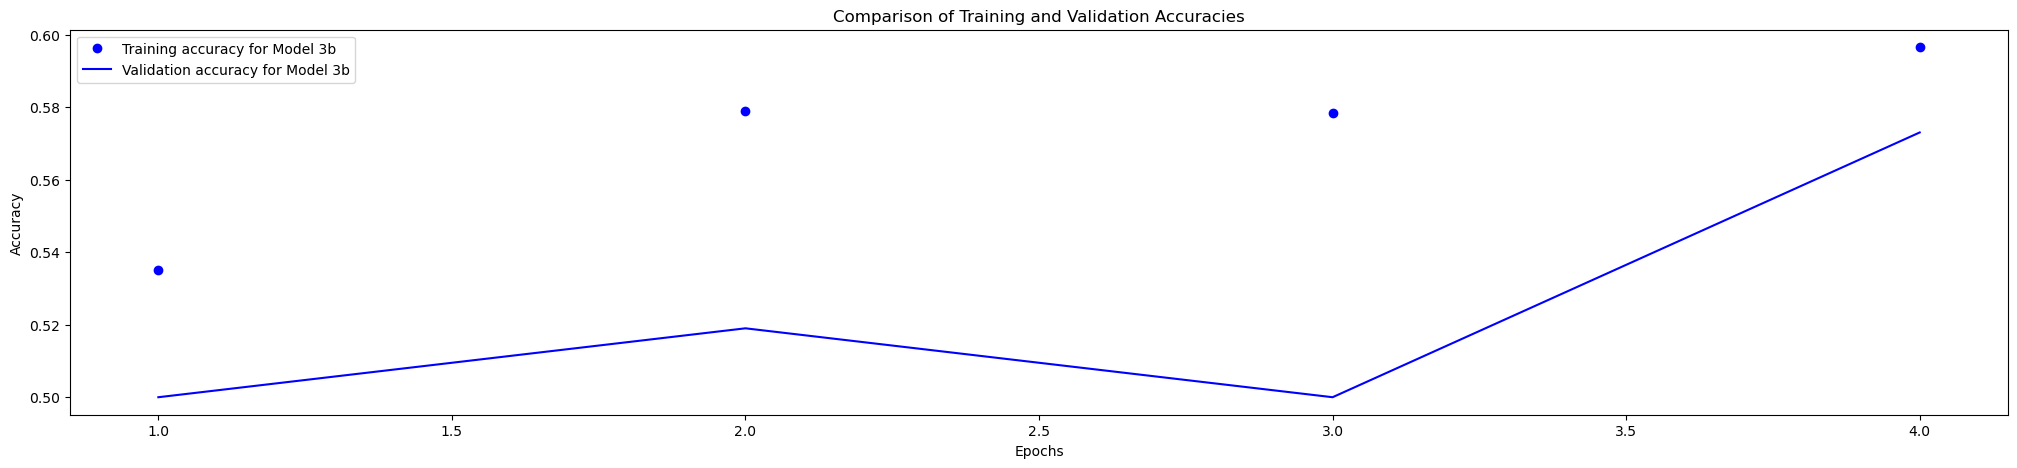

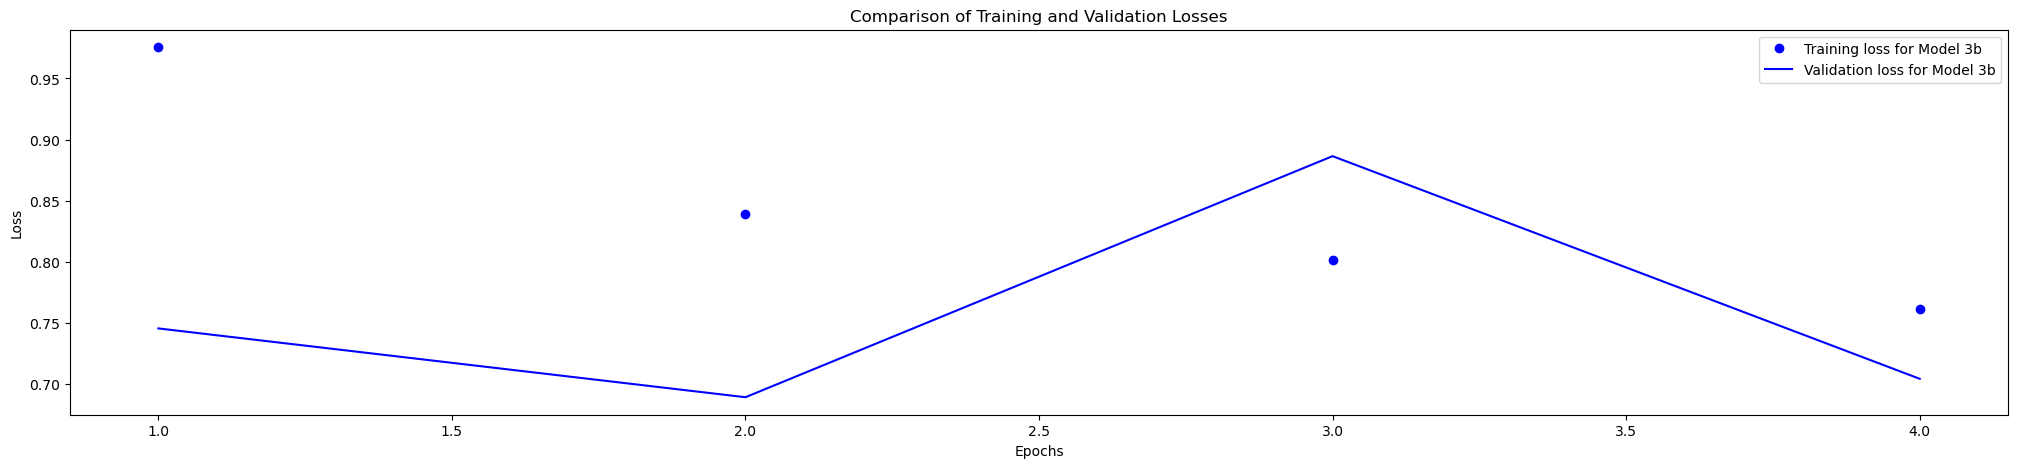

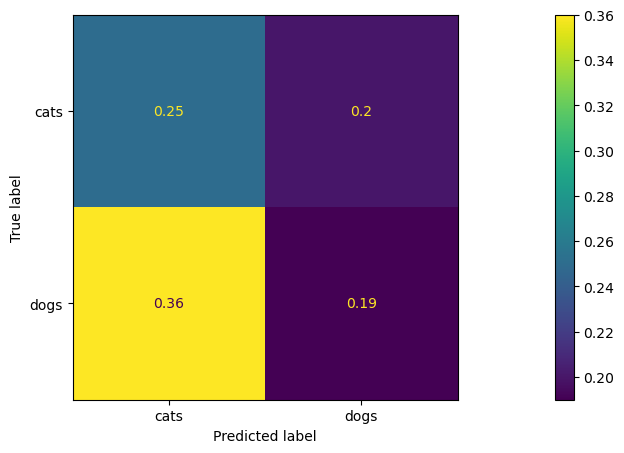

Accuracy: 0.44


In [42]:
plot_accuracy_comparison(history3_b, labels=['Model 3b'])
plot_loss_comparison(history3_b, labels=['Model 3b'])
plot_confusion_matrix(model3_b, validation_generator, 100)

In [43]:
history4_b = model4_b.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4
100/100 [==============================] - 16s 128ms/step - loss: 0.9165 - acc: 0.5335 - val_loss: 0.7542 - val_acc: 0.5000
Epoch 2/4
100/100 [==============================] - 11s 107ms/step - loss: 0.8913 - acc: 0.5460 - val_loss: 0.8447 - val_acc: 0.5000
Epoch 3/4
100/100 [==============================] - 13s 126ms/step - loss: 0.8859 - acc: 0.5470 - val_loss: 1.2383 - val_acc: 0.5000
Epoch 4/4
100/100 [==============================] - 13s 126ms/step - loss: 0.8593 - acc: 0.5515 - val_loss: 0.7630 - val_acc: 0.5170


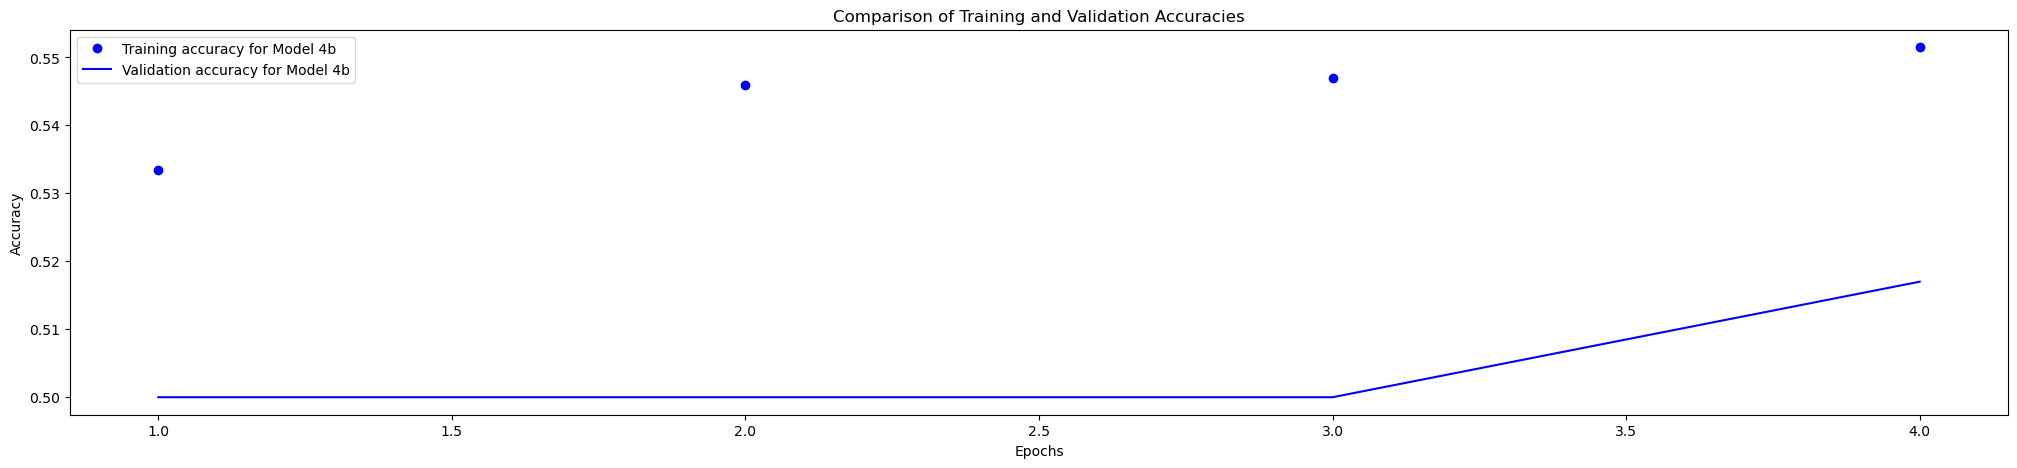

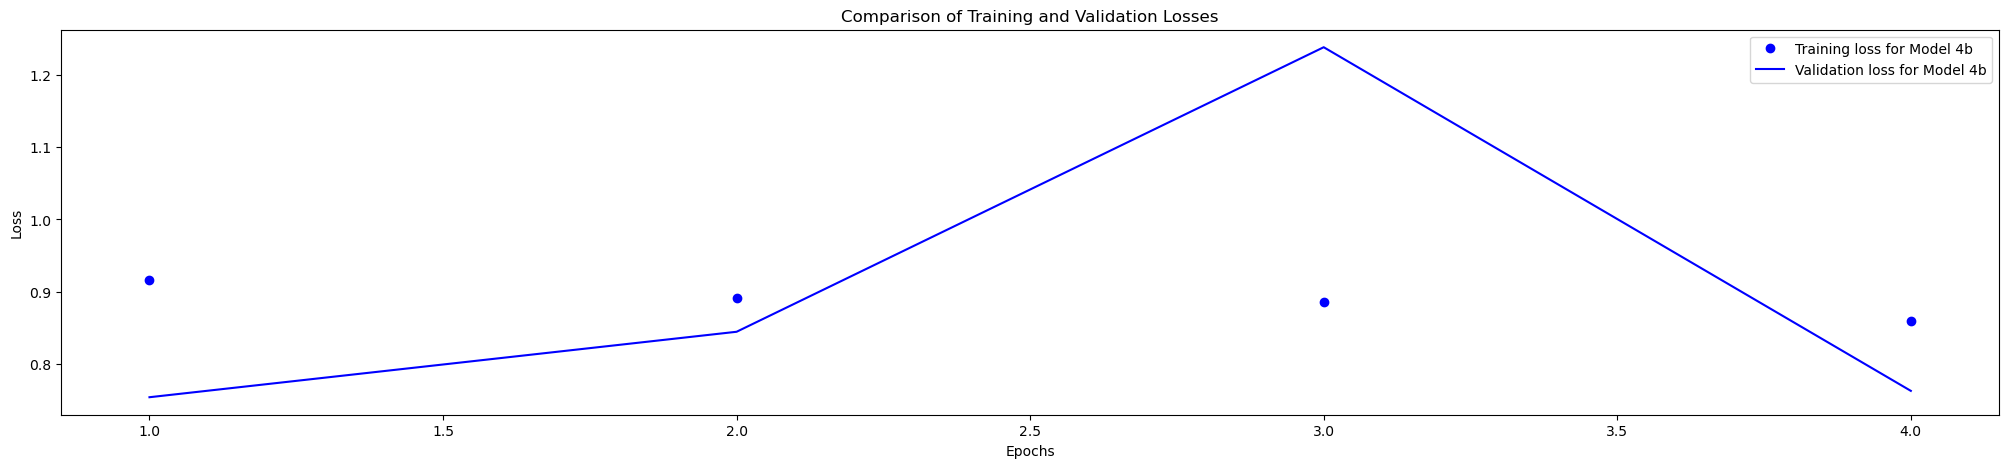

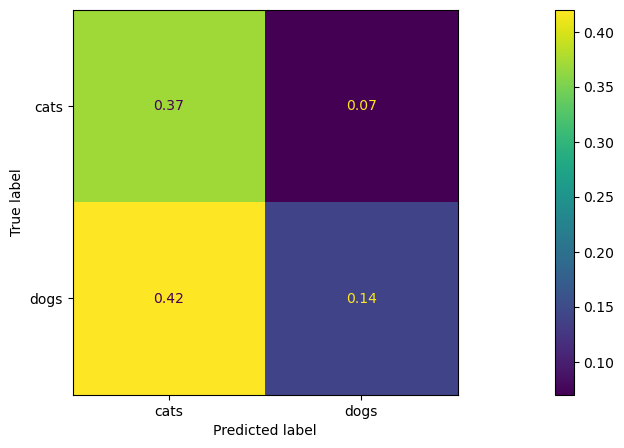

Accuracy: 0.51


In [44]:
plot_accuracy_comparison(history4_b, labels=['Model 4b'])
plot_loss_comparison(history4_b, labels=['Model 4b'])
plot_confusion_matrix(model4_b, validation_generator, 100)

In [45]:
history5_b = model5_b.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4


2024-04-14 02:23:30.356686: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 15s 113ms/step - loss: 0.8634 - acc: 0.5630 - val_loss: 0.7785 - val_acc: 0.5000
Epoch 2/4
100/100 [==============================] - 13s 125ms/step - loss: 0.8489 - acc: 0.5630 - val_loss: 0.6884 - val_acc: 0.5410
Epoch 3/4
100/100 [==============================] - 11s 110ms/step - loss: 0.8005 - acc: 0.5845 - val_loss: 0.9957 - val_acc: 0.5000
Epoch 4/4
100/100 [==============================] - 13s 126ms/step - loss: 0.7917 - acc: 0.5995 - val_loss: 1.0052 - val_acc: 0.4980


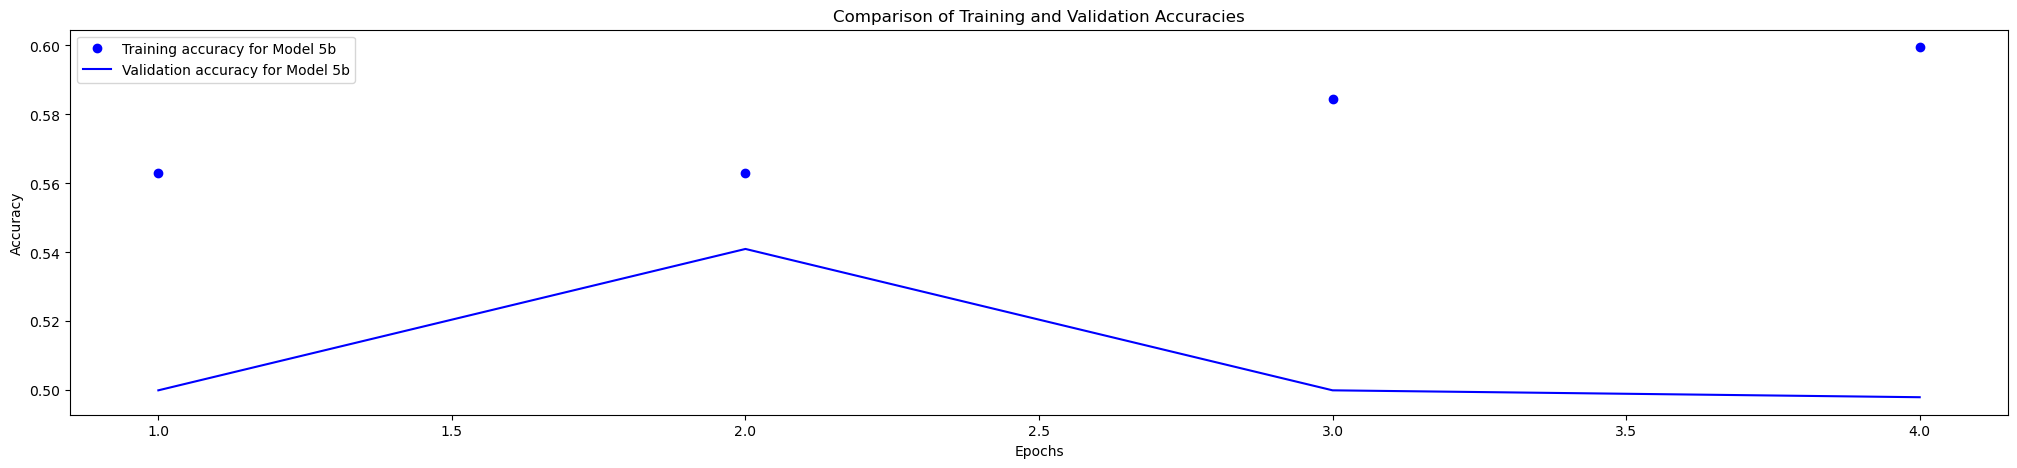

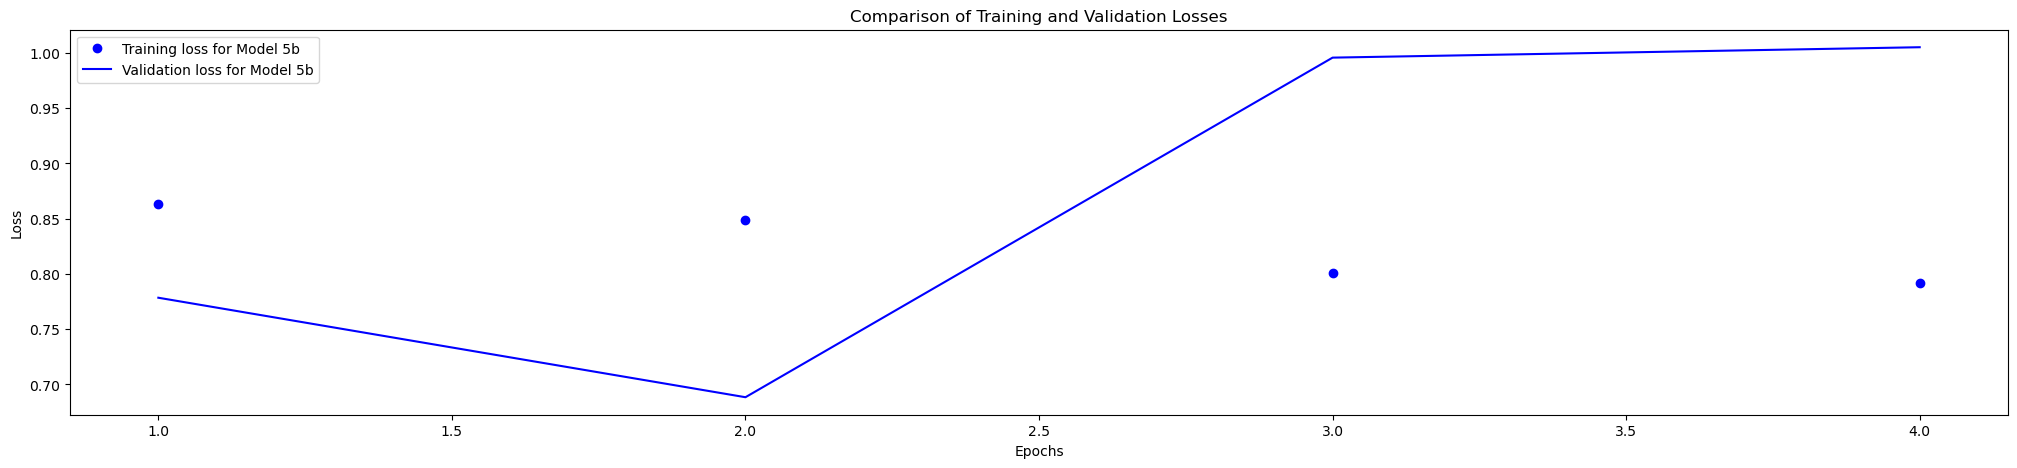

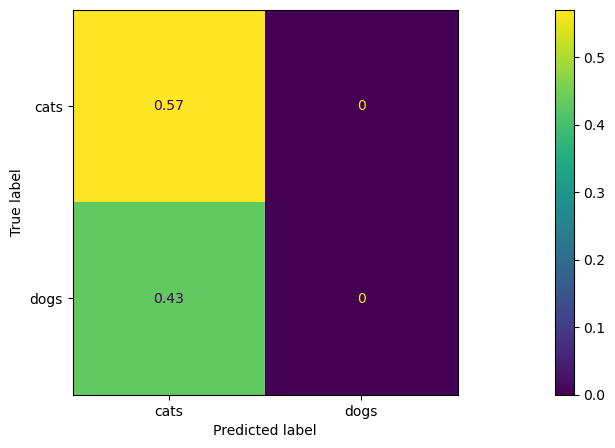

Accuracy: 0.57


In [46]:
plot_accuracy_comparison(history5_b, labels=['Model 5b'])
plot_loss_comparison(history5_b, labels=['Model 5b'])
plot_confusion_matrix(model5_b, validation_generator, 100)

### Save the models

In [47]:
model1_b.save(models_dir + 'cats_and_dogs_1b.keras')
model2_b.save(models_dir + 'cats_and_dogs_2b.keras')
model3_b.save(models_dir + 'cats_and_dogs_3b.keras')
model4_b.save(models_dir + 'cats_and_dogs_4b.keras')
model5_b.save(models_dir + 'cats_and_dogs_5b.keras')


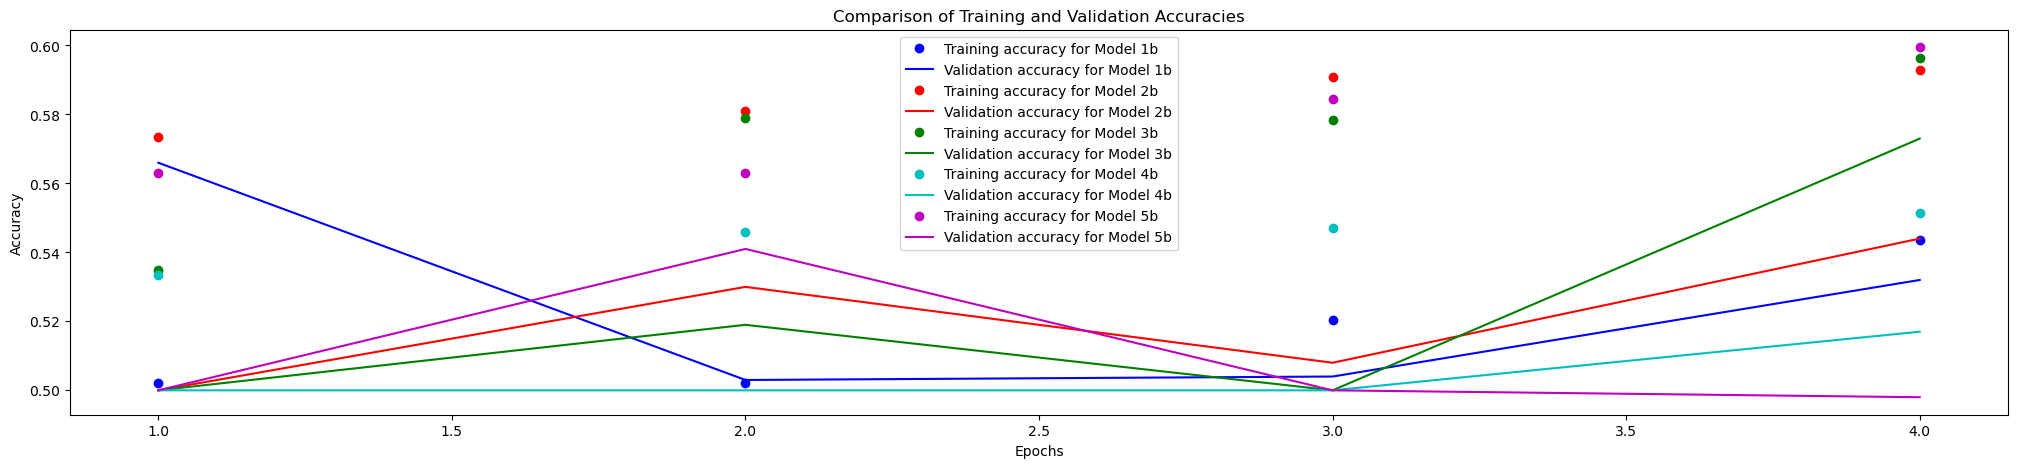

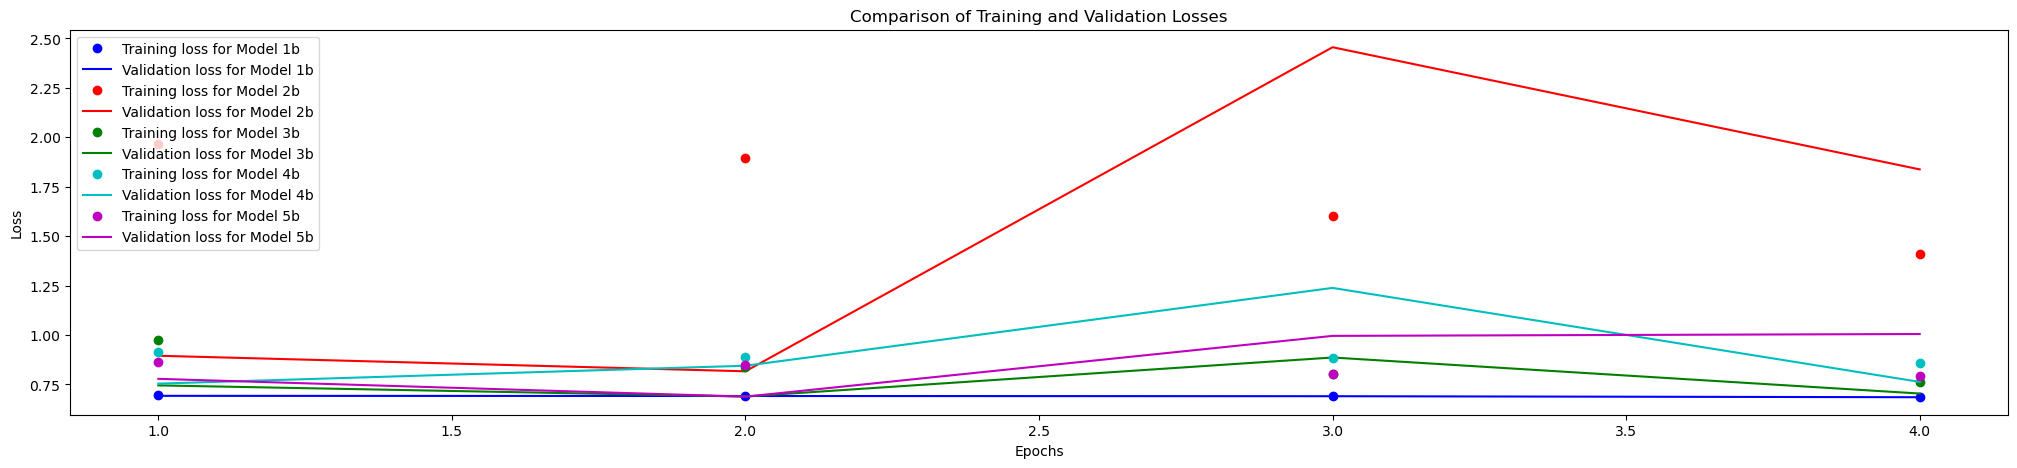

Max accuracy for model 1 is:  0.5659999847412109 , achieved in the  0 epoch.
Max accuracy for model 2 is:  0.5440000295639038 , achieved in the  3 epoch.
Max accuracy for model 3 is:  0.5730000138282776 , achieved in the  3 epoch.


In [48]:
plot_accuracy_comparison(history1_b, history2_b, history3_b, history4_b, history5_b, labels=['Model 1b', 'Model 2b', 'Model 3b', 'Model 4b', 'Model 5b'])
plot_loss_comparison(history1_b, history2_b, history3_b, history4_b, history5_b, labels=['Model 1b', 'Model 2b', 'Model 3b', 'Model 4b', 'Model 5b'])
print_val_accuracies(history1_b, history2_b, history3_b)

# Increase number of training samples - 20000

In [49]:
copy_all_images(max_train_size=20000)

Dirs created
Train images copied
Validation images copied
Test images copied
All images copied


In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        class_mode='binary')

img_rows, img_cols = 150, 150

Found 22000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## CNNs

In [51]:
model1_c = tf.keras.models.clone_model(model1_a)

model1_c.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

model1_c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [52]:
model2_c = tf.keras.models.clone_model(model2_a)

model2_c.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model2_c.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 72, 72, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_7 (Conv2D)           (None, 70, 70, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 70, 70, 128)      

In [53]:
model3_c = tf.keras.models.clone_model(model3_a)

model3_c.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model3_c.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 conv2d_12 (Conv2D)          (None, 144, 144, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 72, 72, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 70, 70, 64)        36928     
                                                                 
 batch_normalization_4 (Bat  (None, 70, 70, 64)        256       
 chNormalization)                                     

In [54]:
model4_c = tf.keras.models.clone_model(model4_a)
model4_c.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model4_c.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_18 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 144, 144, 32)      9248      
                                                                 
 batch_normalization_8 (Bat  (None, 144, 144, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 46, 46, 64)       

In [55]:
model5_c = tf.keras.models.clone_model(model5_a)

model5_c.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model5_c.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_27 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 conv2d_28 (Conv2D)          (None, 144, 144, 32)      9248      
                                                                 
 batch_normalization_14 (Ba  (None, 144, 144, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 46, 46, 64)       

## Learning

In [56]:
history1_c = model1_c.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4
100/100 [==============================] - 13s 109ms/step - loss: 0.6935 - acc: 0.4985 - val_loss: 0.6912 - val_acc: 0.5010
Epoch 2/4
100/100 [==============================] - 13s 128ms/step - loss: 0.6914 - acc: 0.5165 - val_loss: 0.6910 - val_acc: 0.5090
Epoch 3/4
100/100 [==============================] - 11s 108ms/step - loss: 0.6917 - acc: 0.5145 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 4/4
100/100 [==============================] - 13s 125ms/step - loss: 0.6885 - acc: 0.5335 - val_loss: 0.6844 - val_acc: 0.5380


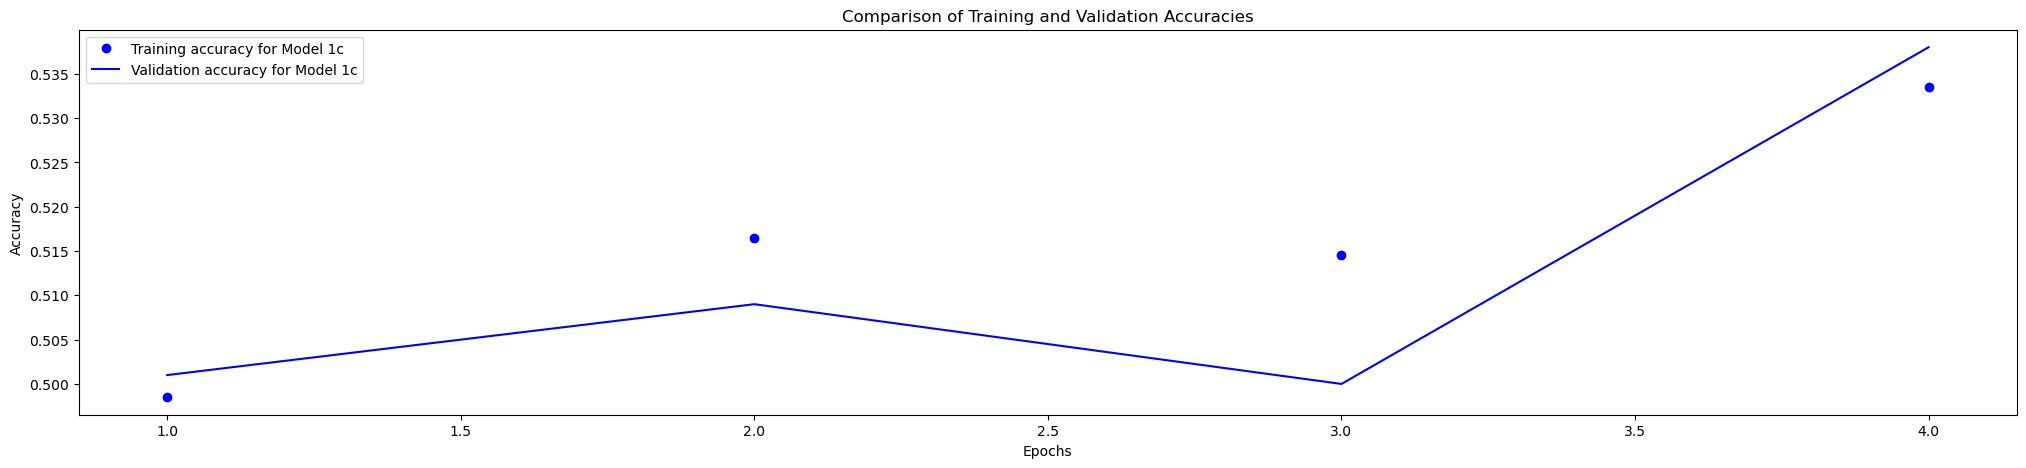

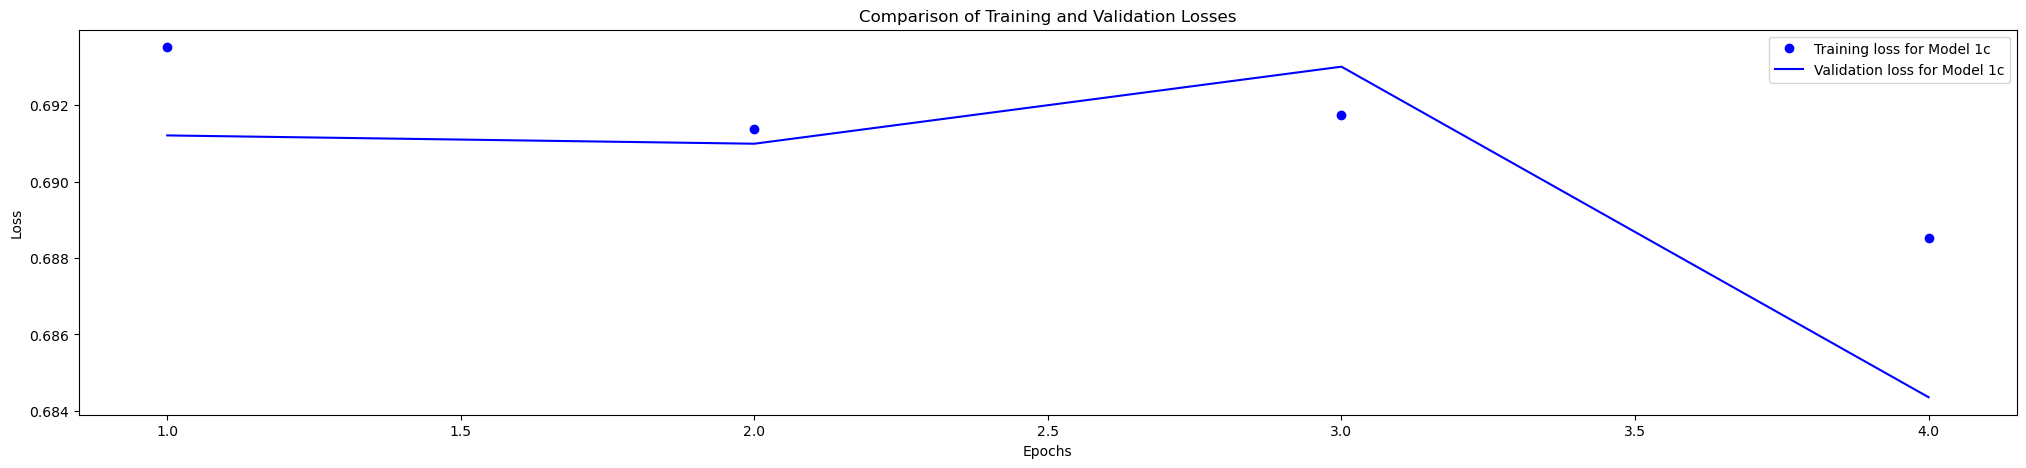

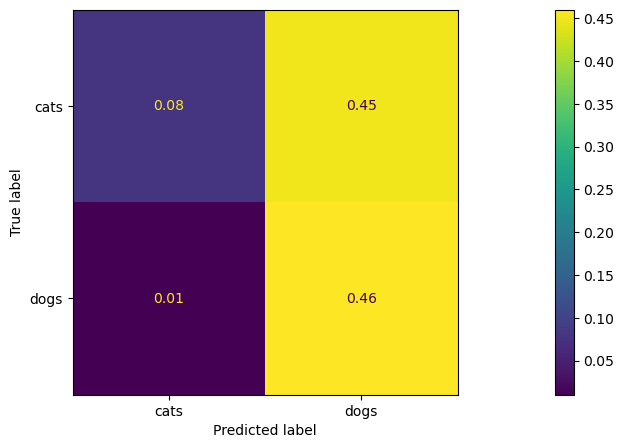

Accuracy: 0.54


In [57]:
plot_accuracy_comparison(history1_c, labels=['Model 1c'])
plot_loss_comparison(history1_c, labels=['Model 1c'])
plot_confusion_matrix(model1_c, validation_generator, 100)

In [58]:
history2_c = model2_c.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4
100/100 [==============================] - 16s 129ms/step - loss: 1.9489 - acc: 0.5820 - val_loss: 0.8475 - val_acc: 0.5000
Epoch 2/4
100/100 [==============================] - 11s 109ms/step - loss: 1.9622 - acc: 0.5950 - val_loss: 0.8746 - val_acc: 0.5400
Epoch 3/4
100/100 [==============================] - 13s 126ms/step - loss: 1.6464 - acc: 0.5900 - val_loss: 1.6349 - val_acc: 0.5180
Epoch 4/4
100/100 [==============================] - 11s 107ms/step - loss: 1.5216 - acc: 0.5850 - val_loss: 2.0668 - val_acc: 0.5950


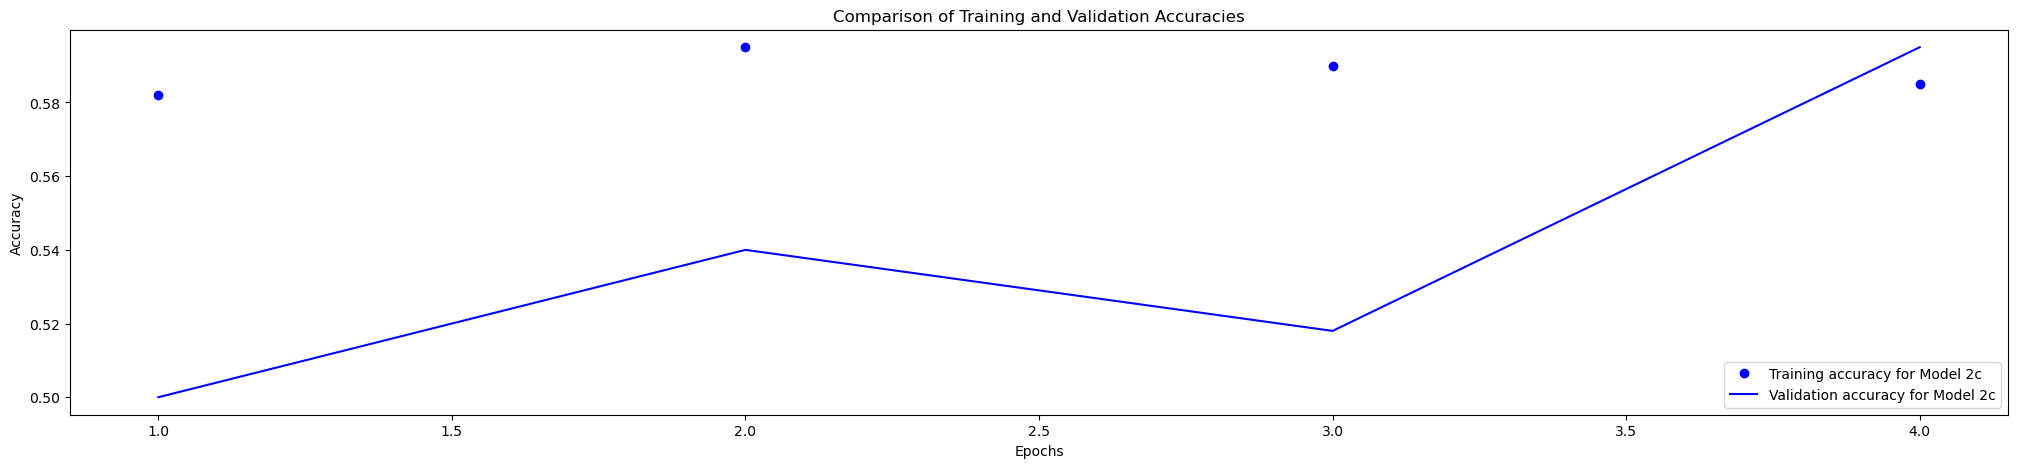

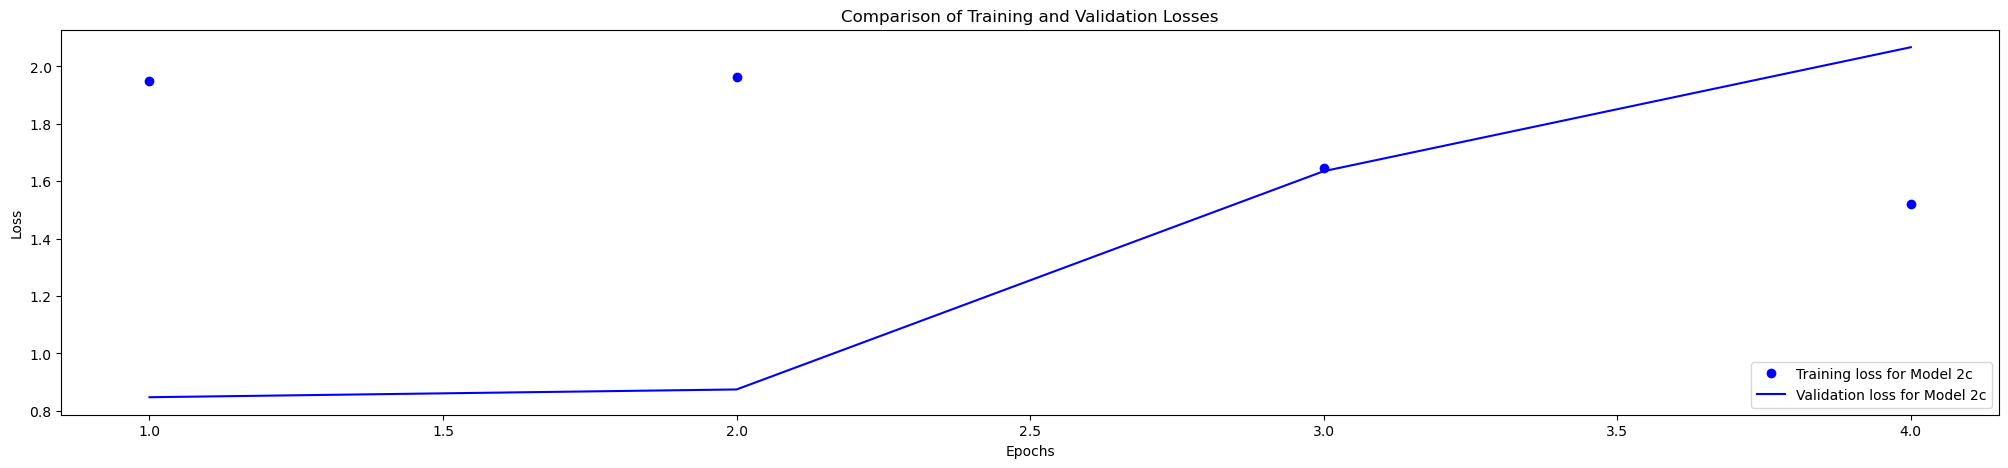

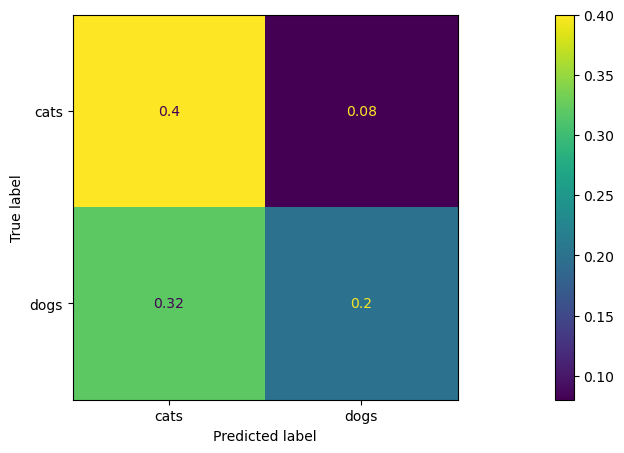

Accuracy: 0.6000000000000001


In [59]:
plot_accuracy_comparison(history2_c, labels=['Model 2c'])
plot_loss_comparison(history2_c, labels=['Model 2c'])
plot_confusion_matrix(model2_c, validation_generator, 100)

In [60]:

history3_c = model3_c.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4


2024-04-14 02:26:12.562158: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 18s 150ms/step - loss: 0.8938 - acc: 0.5600 - val_loss: 0.8192 - val_acc: 0.5000
Epoch 2/4
100/100 [==============================] - 13s 128ms/step - loss: 0.8339 - acc: 0.5610 - val_loss: 0.9834 - val_acc: 0.5000
Epoch 3/4
100/100 [==============================] - 14s 138ms/step - loss: 0.7790 - acc: 0.5875 - val_loss: 0.7404 - val_acc: 0.5000
Epoch 4/4
100/100 [==============================] - 11s 111ms/step - loss: 0.7553 - acc: 0.5765 - val_loss: 0.9161 - val_acc: 0.5000


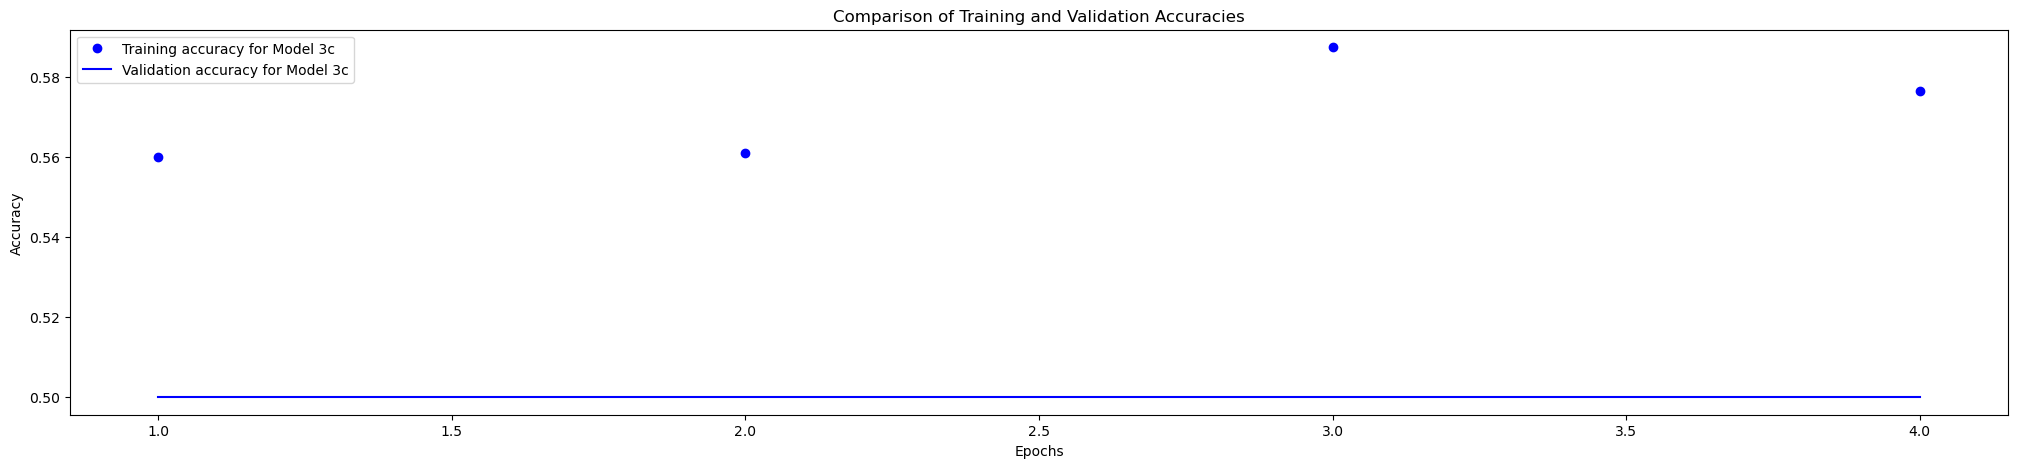

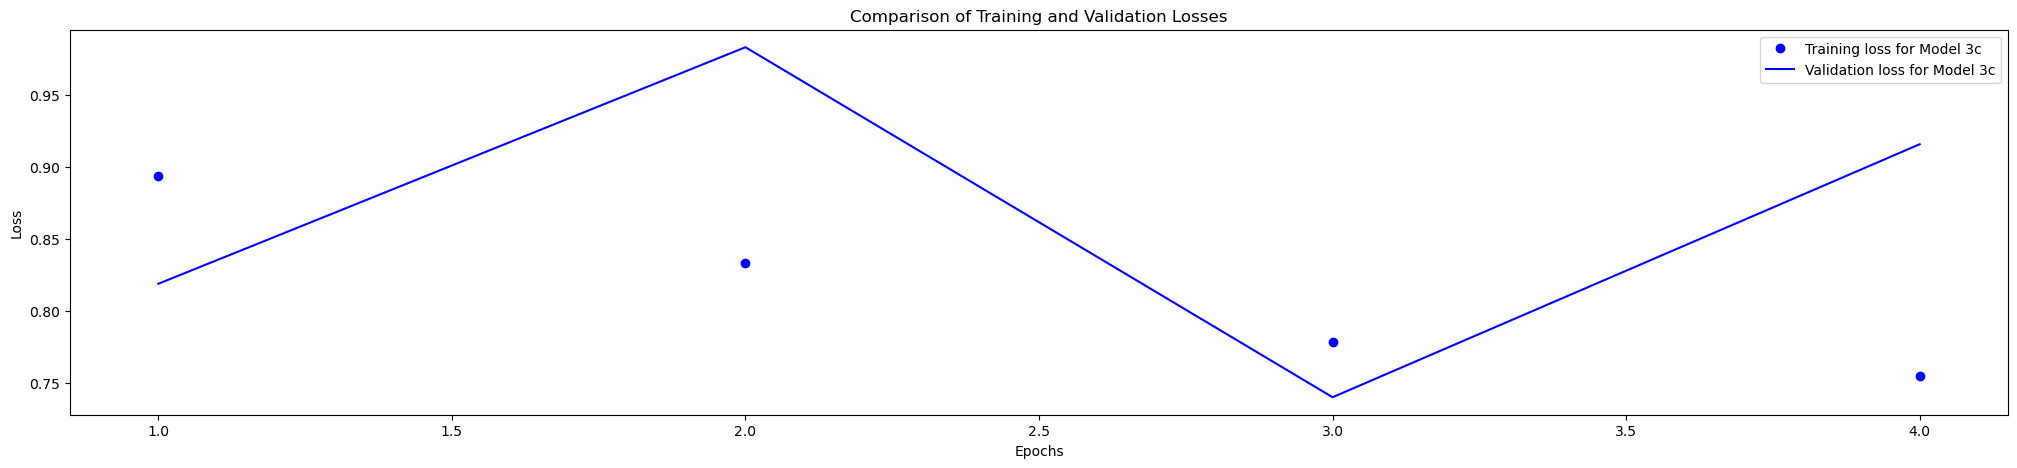

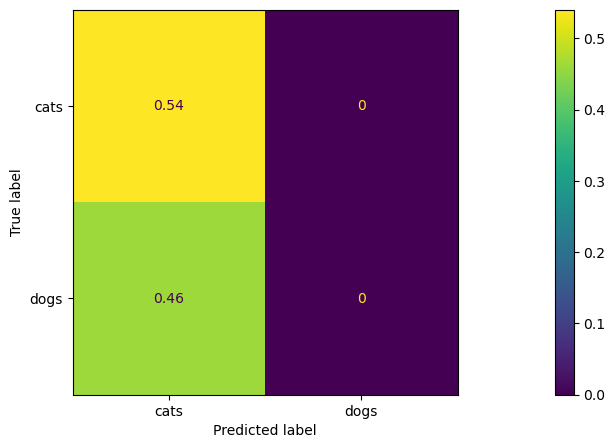

Accuracy: 0.54


In [61]:
plot_accuracy_comparison(history3_c, labels=['Model 3c'])
plot_loss_comparison(history3_c, labels=['Model 3c'])
plot_confusion_matrix(model3_c, validation_generator, 100)

In [62]:
history4_c = model4_c.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4
100/100 [==============================] - 17s 128ms/step - loss: 0.9297 - acc: 0.5335 - val_loss: 0.7146 - val_acc: 0.5000
Epoch 2/4
100/100 [==============================] - 13s 126ms/step - loss: 0.8862 - acc: 0.5580 - val_loss: 1.2181 - val_acc: 0.5000
Epoch 3/4
100/100 [==============================] - 11s 112ms/step - loss: 0.8629 - acc: 0.5675 - val_loss: 1.1221 - val_acc: 0.5000
Epoch 4/4
100/100 [==============================] - 13s 127ms/step - loss: 0.8625 - acc: 0.5610 - val_loss: 0.9788 - val_acc: 0.5030


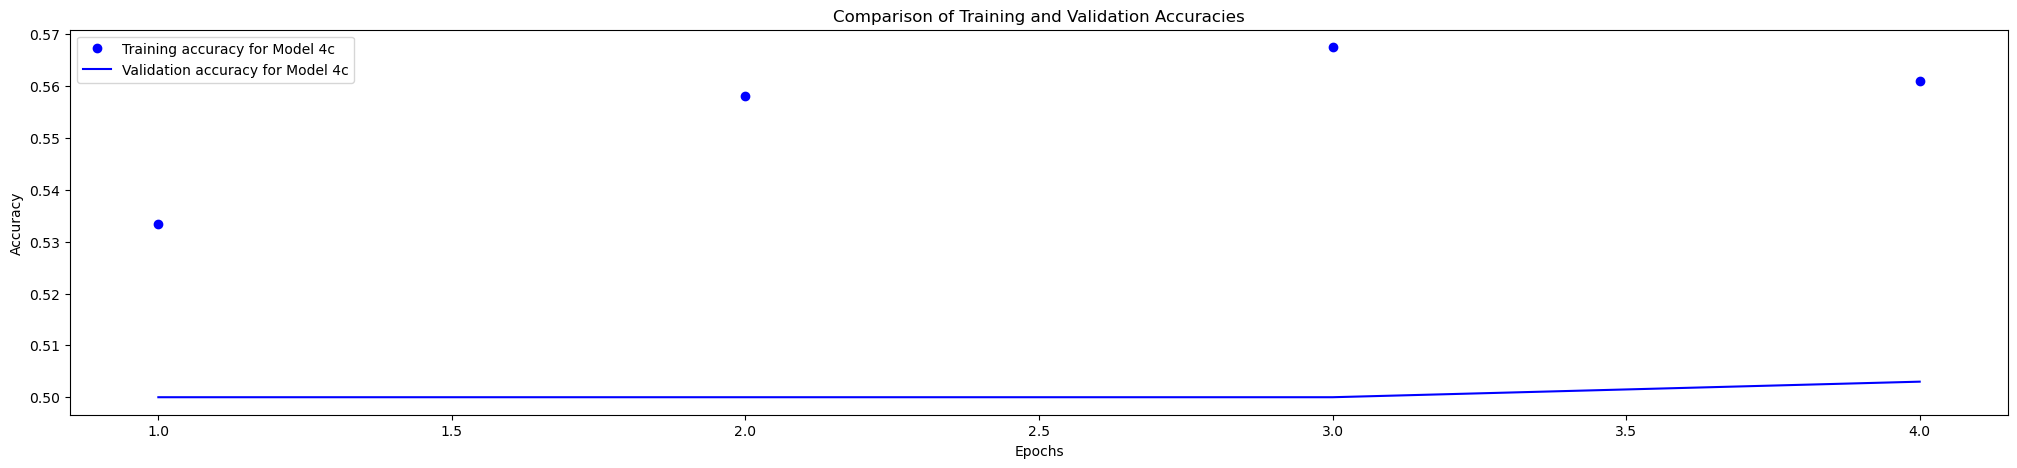

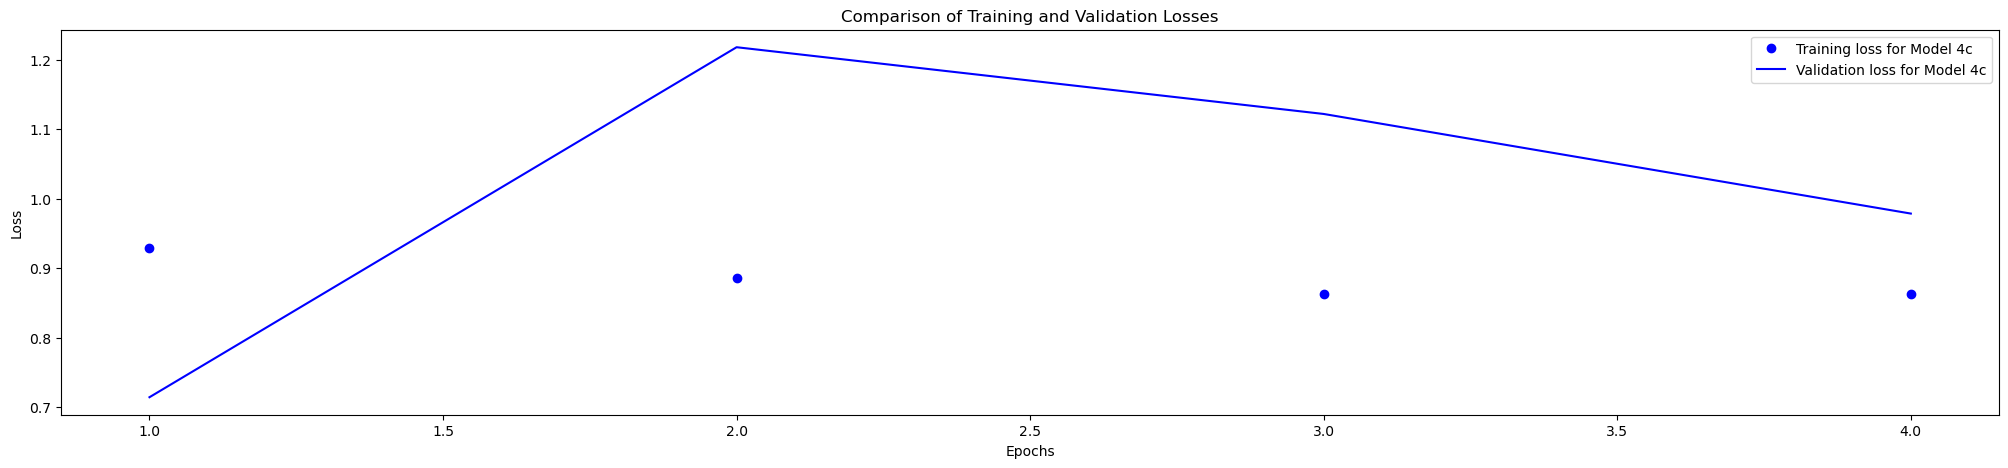

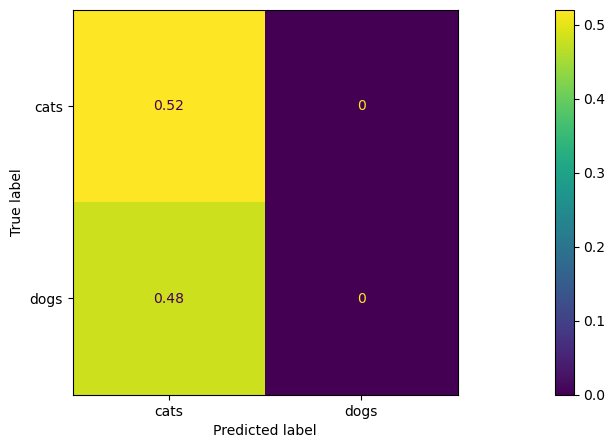

Accuracy: 0.52


In [63]:
plot_accuracy_comparison(history4_c, labels=['Model 4c'])
plot_loss_comparison(history4_c, labels=['Model 4c'])
plot_confusion_matrix(model4_c, validation_generator, 100)

In [64]:
history5_c = model5_c.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/4


2024-04-14 02:28:04.963353: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 15s 112ms/step - loss: 0.8593 - acc: 0.5700 - val_loss: 0.8488 - val_acc: 0.5000
Epoch 2/4
100/100 [==============================] - 13s 128ms/step - loss: 0.8891 - acc: 0.5410 - val_loss: 1.7732 - val_acc: 0.5000
Epoch 3/4
100/100 [==============================] - 11s 110ms/step - loss: 0.8568 - acc: 0.5540 - val_loss: 1.7272 - val_acc: 0.5000
Epoch 4/4
100/100 [==============================] - 13s 125ms/step - loss: 0.8059 - acc: 0.5690 - val_loss: 0.7631 - val_acc: 0.5290


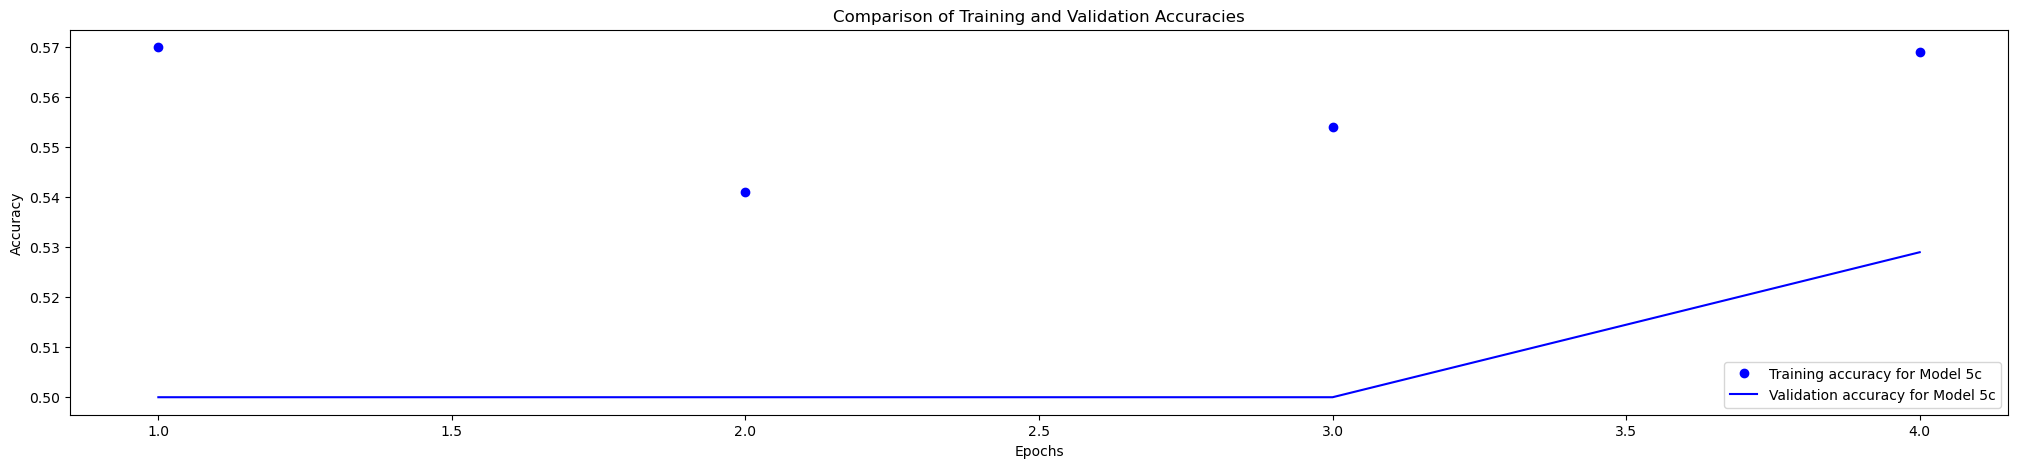

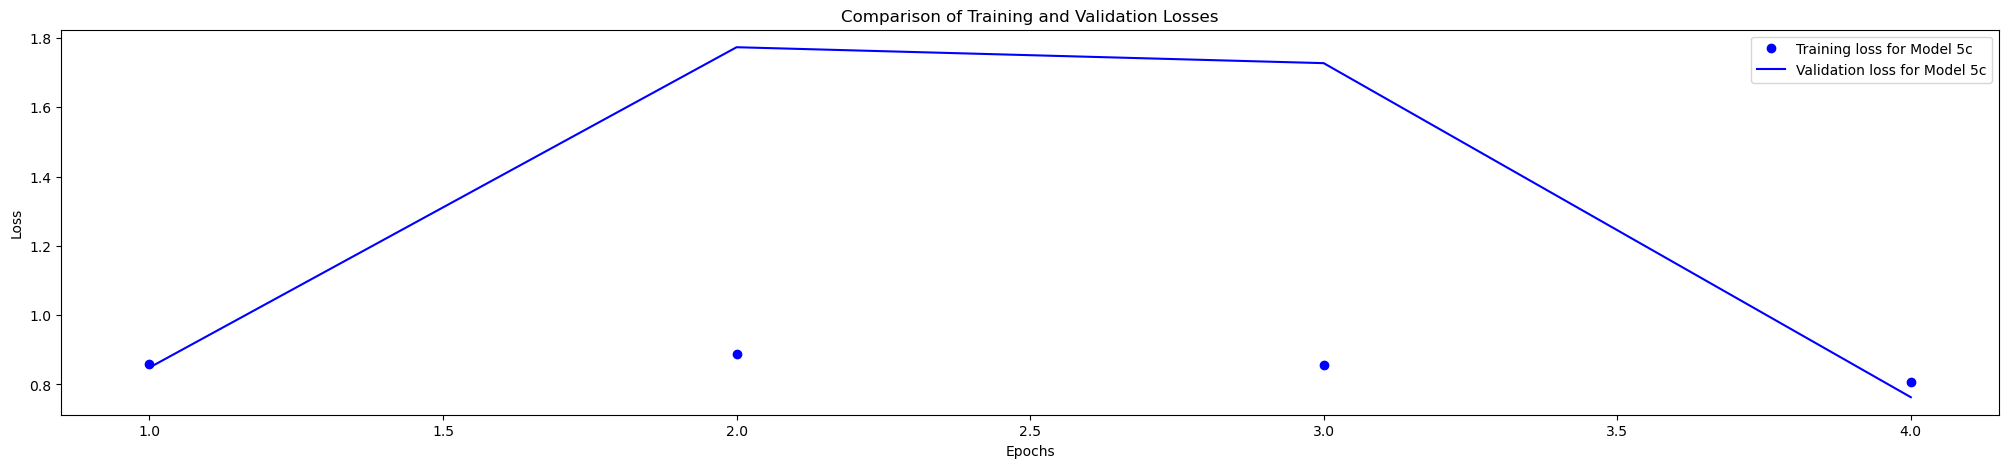

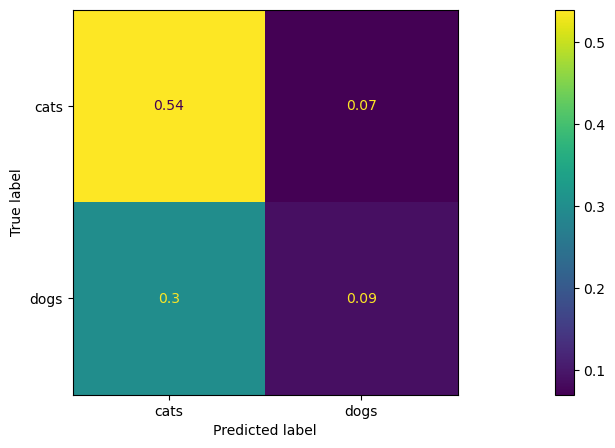

Accuracy: 0.63


In [65]:
plot_accuracy_comparison(history5_c, labels=['Model 5c'])
plot_loss_comparison(history5_c, labels=['Model 5c'])
plot_confusion_matrix(model5_c, validation_generator, 100)

In [66]:
model1_c.save(models_dir + 'cats_and_dogs_small_11.keras')
model2_c.save(models_dir + 'cats_and_dogs_small_12.keras')
model3_c.save(models_dir + 'cats_and_dogs_small_13.keras')
model4_c.save(models_dir + 'cats_and_dogs_small_14.keras')
model5_c.save(models_dir + 'cats_and_dogs_small_15.keras')


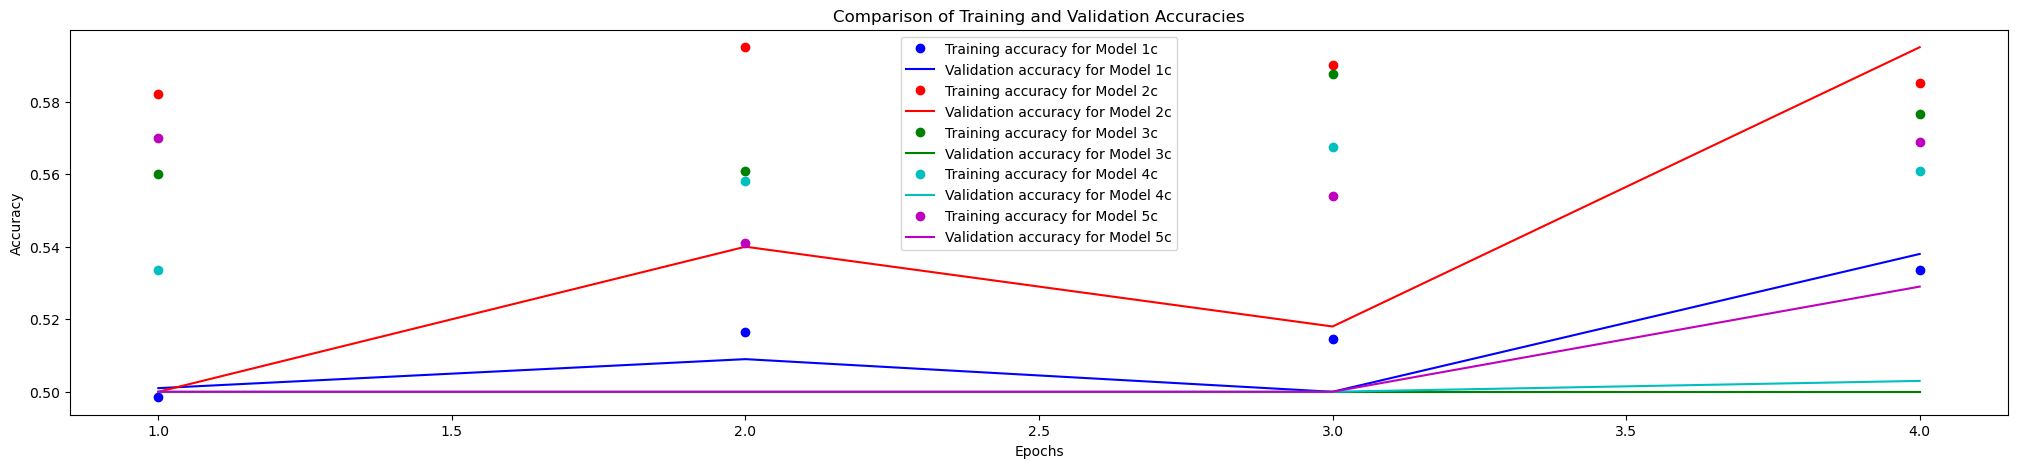

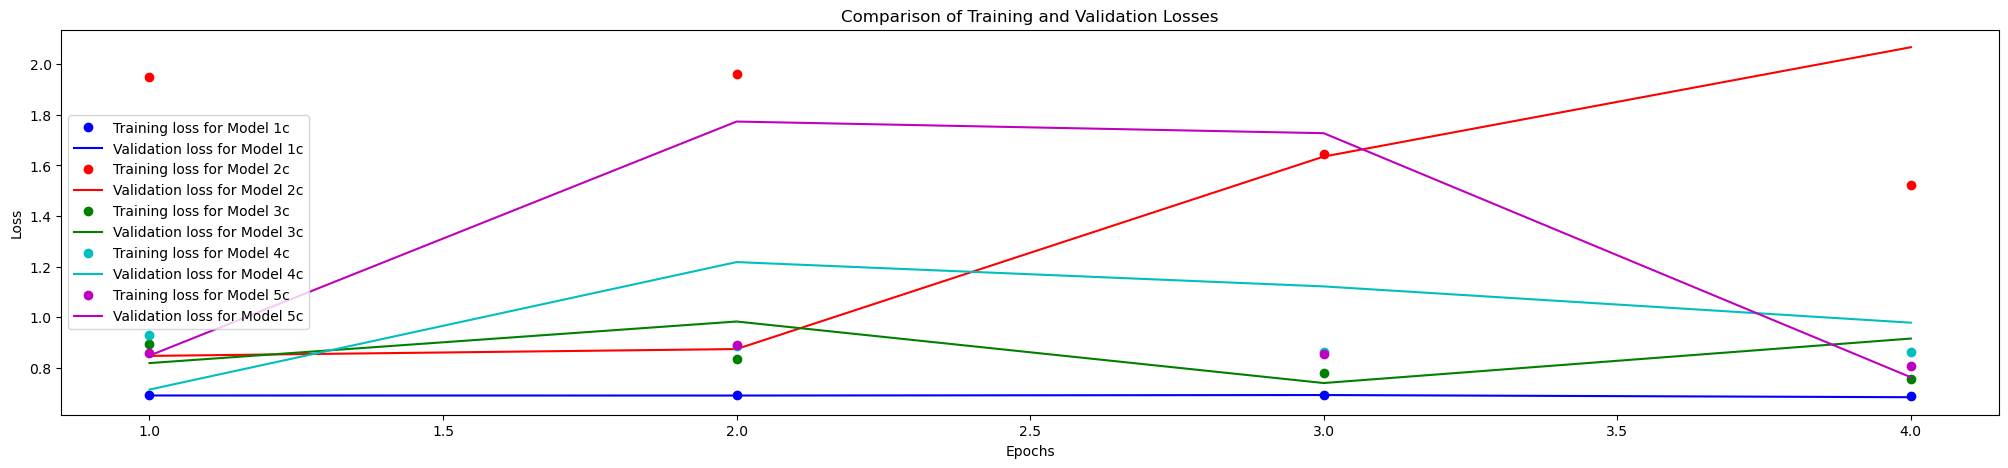

Max accuracy for model 1 is:  0.5379999876022339 , achieved in the  3 epoch.
Max accuracy for model 2 is:  0.5950000286102295 , achieved in the  3 epoch.
Max accuracy for model 3 is:  0.5 , achieved in the  0 epoch.


In [67]:
plot_accuracy_comparison(history1_c, history2_c, history3_c, history4_c, history5_c, labels=['Model 1c', 'Model 2c', 'Model 3c', 'Model 4c', 'Model 5c'])
plot_loss_comparison(history1_c, history2_c, history3_c, history4_c, history5_c, labels=['Model 1c', 'Model 2c', 'Model 3c', 'Model 4c', 'Model 5c'])
print_val_accuracies(history1_c, history2_c, history3_c)

# Conclusion